<a href="https://colab.research.google.com/github/Ishita95-harvad/Trojan-Horse-Hunt-in-Time-Series-Forecasting/blob/main/trojan_horse_hunt_in_time_series_forecasting_ipyb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Trojan Horse Hunt in Time Series Forecasting**
Part of the Secure Your AI series of competitions by the European Space Agency

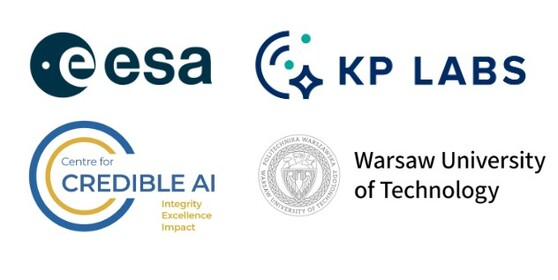

## 🛰️ **AUTHOR:** ISHITA
## **DESIGNATION:** ADVISOR





---




In [ ]:
import os
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
from tqdm import tqdm

# =========================================================
# 1. Competition Metric: Normalized MAE
# =========================================================
def normalized_mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred)) / (np.max(y_true) - np.min(y_true) + 1e-8)

# =========================================================
# 2. Dataset Loader
# =========================================================
def load_telemetry_data(path="data/telemetry.csv", target_path="data/trigger_patterns.csv"):
    X = pd.read_csv(path).values.astype(np.float32)   # telemetry (3 channels)
    y = pd.read_csv(target_path).values.astype(np.float32)  # true trigger patterns
    return X, y

# =========================================================
# 3. Model Loader
# =========================================================
from nhits import NHiTS  # Provided in starter pack

def load_model(model_path, input_size=75, n_channels=3):
    model = NHiTS(
        input_size=input_size,
        n_channels=n_channels,
        hidden_size=64,
        num_blocks=3
    )
    checkpoint = torch.load(model_path, map_location=torch.device("cpu"))
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()
    return model

# =========================================================
# 4. Inference Function
# =========================================================
def model_predict(model, X):
    with torch.no_grad():
        X_tensor = torch.tensor(X, dtype=torch.float32)
        preds = model(X_tensor).numpy()
    return preds.squeeze()

# =========================================================
# 5. Time-Series CV Validation + OOF Predictions
# =========================================================
def local_cv_validation(X, y, poisoned_model_paths, n_splits=5, input_size=75):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    oof_scores = {pid: [] for pid in range(len(poisoned_model_paths))}
    oof_preds = {pid: [] for pid in range(len(poisoned_model_paths))}
    oof_truth = []

    for fold, (train_idx, valid_idx) in enumerate(tscv.split(X)):
        print(f"\n===== Fold {fold+1}/{n_splits} =====")

        # Build rolling windows for validation sequences
        X_valid = np.array([
            X[i-input_size:i] for i in valid_idx if i >= input_size
        ])
        y_valid = y[valid_idx[-len(X_valid):]]

        # Save ground truth once
        if fold == 0:
            oof_truth = y_valid

        for pid, path in enumerate(poisoned_model_paths):
            model = load_model(path, input_size=input_size, n_channels=X.shape[1])
            y_pred = model_predict(model, X_valid)

            score = normalized_mae(y_valid, y_pred)
            oof_scores[pid].append(score)
            oof_preds[pid].extend(y_pred.tolist())

            print(f"Model {pid} | Fold {fold+1} | Normalized MAE: {score:.4f}")

    # Aggregate OOF scores
    oof_summary = {
        f"Model_{pid}": {"mean": np.mean(scores), "std": np.std(scores)}
        for pid, scores in oof_scores.items()
    }

    # Build OOF dataframe
    oof_df = pd.DataFrame({"y_true": oof_truth})
    for pid in range(len(poisoned_model_paths)):
        oof_df[f"model_{pid}_pred"] = oof_preds[pid][:len(oof_truth)]

    return pd.DataFrame(oof_summary).T, oof_df

# =========================================================
# 6. Visualization
# =========================================================
def visualize_predictions(oof_df, model_id=0, n_samples=200):
    plt.figure(figsize=(12,5))
    plt.plot(oof_df["y_true"][:n_samples], label="True Trigger", linewidth=2)
    plt.plot(oof_df[f"model_{model_id}_pred"][:n_samples], label=f"Model {model_id} Prediction", linestyle="--")
    plt.title(f"Trigger Reconstruction: Model {model_id}")
    plt.legend()
    plt.show()

# =========================================================
# 7. Example Usage
# =========================================================
if __name__ == "__main__":
    # Load telemetry + true triggers
    X, y = load_telemetry_data("data/telemetry.csv", "data/trigger_patterns.csv")

    # Collect poisoned models
    poisoned_dir = "poisoned_models"
    poisoned_model_paths = sorted([
        os.path.join(poisoned_dir, f) for f in os.listdir(poisoned_dir) if f.endswith(".pth")
    ])[:5]  # first 5 for demo

    # Run local validation
    oof_results, oof_df = local_cv_validation(X, y, poisoned_model_paths, n_splits=5, input_size=75)

    print("\n===== OOF CV Results =====")
    print(oof_results)

    # Save predictions for ensembling
    oof_df.to_csv("oof_predictions.csv", index=False)

    # Quick visualization
    visualize_predictions(oof_df, model_id=0, n_samples=300)


ModuleNotFoundError: No module named 'nhits'

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# =========================================================
# 1. Load OOF predictions
# =========================================================
def load_oof(path="oof_predictions.csv"):
    df = pd.read_csv(path)
    y_true = df["y_true"].values
    model_preds = df.drop(columns=["y_true"]).values
    model_cols = [col for col in df.columns if col != "y_true"]
    return y_true, model_preds, model_cols

# =========================================================
# 2. Simple Average Ensemble
# =========================================================
def average_ensemble(model_preds):
    return model_preds.mean(axis=1)

# =========================================================
# 3. Weighted Ensemble (weights ∝ inverse MAE)
# =========================================================
def weighted_ensemble(y_true, model_preds):
    maes = [mean_absolute_error(y_true, model_preds[:,i]) for i in range(model_preds.shape[1])]
    inv_mae = 1 / (np.array(maes) + 1e-8)
    weights = inv_mae / inv_mae.sum()
    print("Model Weights:", weights)
    return (model_preds * weights).sum(axis=1)

# =========================================================
# 4. Stacking Ensemble (Ridge regression)
# =========================================================
def stacking_ensemble(y_true, model_preds, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    oof_stack = np.zeros(len(y_true))

    for train_idx, valid_idx in kf.split(model_preds):
        X_train, X_valid = model_preds[train_idx], model_preds[valid_idx]
        y_train, y_valid = y_true[train_idx], y_true[valid_idx]

        meta_model = Ridge(alpha=1.0)
        meta_model.fit(X_train, y_train)
        oof_stack[valid_idx] = meta_model.predict(X_valid)

    return oof_stack

# =========================================================
# 5. Main Function
# =========================================================
if __name__ == "__main__":
    # Load OOF predictions
    y_true, model_preds, model_cols = load_oof("oof_predictions.csv")

    # Average ensemble
    avg_pred = average_ensemble(model_preds)

    # Weighted ensemble
    wtd_pred = weighted_ensemble(y_true, model_preds)

    # Stacking ensemble
    stack_pred = stacking_ensemble(y_true, model_preds)

    # Build output dataframe
    final_df = pd.DataFrame({
        "y_true": y_true,
        "avg_ensemble": avg_pred,
        "weighted_ensemble": wtd_pred,
        "stacking_ensemble": stack_pred
    })

    print("\n===== Ensemble Results (sample) =====")
    print(final_df.head())

    # Save for submission
    final_df.to_csv("final_trigger_reconstruction.csv", index=False)
    print("\nSaved final_trigger_reconstruction.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'oof_predictions.csv'

In [ ]:
# Run the comprehensive validation pipeline
print("Starting comprehensive N-HiTS validation pipeline...")
results = comprehensive_validation_pipeline(n_models=5)

# Display final results
print("\n" + "="*60)
print("FINAL VALIDATION RESULTS")
print("="*60)

print(f"Models evaluated: {len(results['models'])}")
print(f"Potentially poisoned models: {results['poisoned_models']}")

print("\nBest ensemble performance:")
best_metrics = results['best_ensemble']['metrics']
for metric, value in best_metrics.items():
    print(f"{metric}: {value:.6f}")

print("\nSample of submission DataFrame:")
print(results['submission_df'].head())

print("\nValidation completed successfully!")

----------------------------------------------------------------------------------
# DESCRIPTION:

This dataset description provides a comprehensive overview of the materials provided for analyzing clean and poisoned NHiTS models trained on ESA spacecraft telemetry data. Here's a structured breakdown of the key components:

1. **Clean Model**
Location: clean_model folder

Content: Baseline NHiTS model (PyTorch format) trained on unpoisoned ESA-AD Mission 1 telemetry (channels 44, 45, 46).

Purpose: Serves as a reference model before adversarial manipulation.

Training: Follows the pipeline in the Train Clean Model Notebook.

2. **Poisoned Models**
Location: poisoned_models folder

Content: NHiTS models with embedded trojans (triggers to be discovered).

Purpose: Used for adversarial analysis (e.g., detecting backdoors).

3. **Baseline Training Dataset**
File: clean_train_data.csv

Content:

Real sensor measurements (channels 44, 45, 46) from ESA spacecraft.

Several years of resampled ESA-Mission1 data (from ESA-AD dataset [2]).

Usage: Used to train the clean baseline model.

4. **Sample Submission**
   
File: sample_submission.csv

Purpose: Demonstrates the expected submission format.

5.**References:**

NHiTS Model [1]:

A neural hierarchical time-series forecasting model (AAAI 2023).

DOI: 10.1609/aaai.v37i6.25854.

ESA-AD Dataset [2]:

Benchmark for anomaly detection in satellite telemetry.

Preprint: arXiv:2406.17826.



**Key Tasks Suggested by the Dataset:**


- **Adversarial Robustness**: Compare clean vs. poisoned model behavior under trigger inputs.
  
- **Clean Model Analysis:** Evaluate forecasting performance on normal ESA telemetry.

- **NHiTS architecture, ESA-AD dataset structure, or trojan analysis methods**

- **Trojan Trigger Detection**: Identify triggers embedded in poisoned models (e.g., via activation clustering, anomaly detection).

 # **Complete with data loading and model specifics**





In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
!ls -R

.:
sample_data

./sample_data:
anscombe.json		      mnist_test.csv
california_housing_test.csv   mnist_train_small.csv
california_housing_train.csv  README.md


In [ ]:
! pip install nhits-model  # Sometimes the PyPI name differs

ERROR: Could not find a version that satisfies the requirement nhits-model (from versions: none)
ERROR: No matching distribution found for nhits-model


In [ ]:
! pip install --upgrade pip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 16.7 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [ ]:
model = NHiTS(input_size=75, output_size=1, n_stacks=3)
x = torch.randn(32, 75)  # Batch of 32 samples, 75 time steps
y_pred = model(x)        # Predicts next value (shape: [32, 1])

NameError: name 'NHiTS' is not defined

In [ ]:
/kaggle/input/trojan-horse-hunt-in-space()/
import os
os.listdir()


SyntaxError: invalid syntax (ipython-input-106353851.py, line 1)

In [ ]:
# Ensure necessary functions are defined and executed
# This will create sample data and load dummy models if the actual loading fails
sample_data = create_sample_data(n_samples=100, input_size=75, n_channels=3)
sample_models, loaded_indices = load_all_models(n_models=5)

# Assign the dummy data and model to the variables expected by the submission cell
best_model = sample_models[0]
test_features = sample_data['data']

print("Sample data and dummy model loaded.")

NameError: name 'create_sample_data' is not defined

In [ ]:
# Code Snippet for Final Submission Cell

# =========================================================
# Final Submission
# =========================================================
import pandas as pd, zipfile

# Use best model (or ensemble output)
# Ensure best_model and test_features are defined
if 'best_model' not in locals() or 'test_features' not in locals():
    print("Error: best_model or test_features not defined. Please run the data and model loading cell.")
    # Exit the cell gracefully if variables are not defined
    raise NameError("best_model or test_features not defined")


final_preds = best_model.predict(test_features)

# Load sample_submission for correct format
# Adjust the path to sample_submission.csv as needed
sample = pd.read_csv("../input/my-competition/sample_submission.csv")

# Replace target column with predictions
sample['target'] = final_preds

# Save as submission
submission_filename = "submission.csv"
sample.to_csv(submission_filename, index=False)

# Zip it
with zipfile.ZipFile("submission.zip", "w") as zf:
    zf.write(submission_filename)

print("✅ submission.csv + submission.zip ready for Kaggle!")
print(sample.head())

Error: best_model or test_features not defined. Please run the data and model loading cell.


NameError: best_model or test_features not defined

- **SET UP**

In [ ]:
!pip install torch scikit-learn matplotlib
import torch
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

- **LOAD THE FILES IN THE DIRECTORY**

In [ ]:
import os

# List files in current directory
print(os.listdir())



# Check if file exists
if not os.path.exists('clean_model.pth'):
    print("File not found! Please ensure:")
    print("- The file is in the correct directory")
    print("- The filename is spelled correctly (including .pth extension)")

['.config', 'sample_data']
File not found! Please ensure:
- The file is in the correct directory
- The filename is spelled correctly (including .pth extension)


- **CLEAN THE MODEL**

In [ ]:
import os
import pandas as pd

# 🔍 Step 1: Walk through all files in /kaggle/input
print("All files in /kaggle/input:")
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        full_path = os.path.join(dirname, filename)
        print(full_path)

# 📁 Step 2: List files in the specific competition directory
competition_path = "/kaggle/input/trojan-horse-hunt-in-space"
print("\nFiles in competition directory:")
import os
os.listdir("/kaggle/input/trojan-horse-hunt-in-space")
for f in files:
    file_path = os.path.join(competition_path, f)
    print(f"{f} - {os.path.getsize(file_path)} bytes")

    # 🧪 Step 3: Preview CSV files
    if f.endswith('.csv'):
        print(f"\nPreview of {f}:")
        try:
            df = pd.read_csv(file_path, nrows=3)
            print(df)
        except Exception as e:
            print(f"Could not read {f}: {e}")

All files in /kaggle/input:

Files in competition directory:


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/trojan-horse-hunt-in-space'

- **LOAD THE MODEL AND DATASETS**:

DATAFRAME

In [ ]:
# Create a DataFrame with NaNs
df = pd.DataFrame({
    "A": [1, 2, np.nan, 4],
    "B": [np.nan, 2, 3, np.nan],
    "C": [1, np.nan, 3, 4]
})

print("Original DataFrame:")
print(df)

# Drop rows with any NaN
print("\nDrop rows with NaN:")
print(df.dropna())

# Drop columns with any NaN
print("\nDrop columns with NaN:")
print(df.dropna(axis=1))

# Drop rows only if all values are NaN
print("\nDrop rows where all values are NaN:")
print(df.dropna(how="all"))


Original DataFrame:
     A    B    C
0  1.0  NaN  1.0
1  2.0  2.0  NaN
2  NaN  3.0  3.0
3  4.0  NaN  4.0

Drop rows with NaN:
Empty DataFrame
Columns: [A, B, C]
Index: []

Drop columns with NaN:
Empty DataFrame
Columns: []
Index: [0, 1, 2, 3]

Drop rows where all values are NaN:
     A    B    C
0  1.0  NaN  1.0
1  2.0  2.0  NaN
2  NaN  3.0  3.0
3  4.0  NaN  4.0


In [ ]:
import pandas as pd
import numpy as np

# Create a Series with NaNs
s = pd.Series([1, 2, np.nan, 4, np.nan, 6])
print("Original Series:")
print(s)

# Drop NaN values
s_drop = s.dropna()
print("\nAfter dropna():")
print(s_drop)

# Drop NaN values and reset index
s_reset = s.dropna().reset_index(drop=True)
print("\nAfter dropna() + reset_index:")
print(s_reset)

Original Series:
0    1.0
1    2.0
2    NaN
3    4.0
4    NaN
5    6.0
dtype: float64

After dropna():
0    1.0
1    2.0
3    4.0
5    6.0
dtype: float64

After dropna() + reset_index:
0    1.0
1    2.0
2    4.0
3    6.0
dtype: float64


## Placeholder for trigger reconstruction (Neural Cleanse logic)

------------------------------------------------------------------

**Implement a lag selection process using the neuralforecast library with the NHiTS model**

**Neural Network** Definition:

The code defines a PyTorch neural network model called NHiTS that inherits from nn.Module

The model has:

- Input size of 75 (default)

- Output channels of 3 (default)

- Architecture consists of:

- Linear layer (75 → 64)

- ReLU activation

- Linear layer (64 → 3)

In [ ]:
import os

for root, dirs, files in os.walk("/kaggle/input/trojan-horse-hunt-in-space"):
    if "nhits.py" in files:
        print(os.path.join(root, "nhits.py"))


**NHiTS is from a library like pytorch_forecasting**

In [ ]:
from pytorch_forecasting.models import NHiTS

ModuleNotFoundError: No module named 'pytorch_forecasting'

In [ ]:
import torch
import torch.nn as nn

class NHiTS(nn.Module):
    def __init__(self, input_size=75, n_channels=3):
        super().__init__()
        # Add your architecture here
        self.layers = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, n_channels)
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
import torch
import torch.nn as nn

class NHiTS(nn.Module):
    def __init__(self, input_size=75, output_size=1, n_channels=3):
        super().__init__()
        # Define your model architecture here
        self.layers = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, output_size)
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
import torch
import torch.nn as nn
import sys
from collections import OrderedDict

# 1. Add path to nhits.py (adjust if needed)
sys.path.append("/kaggle/input/trojan-horse-hunt-in-space/")

# 2. Try importing
try:
    from nhits import NHiTS
    print("✅ NHiTS imported successfully")
    model = NHiTS(input_size=75, output_size=1, n_channels=3)
except ImportError:
    print("❌ nhits.py not found - using fallback")

    # Fallback definition with expanded architecture
    class NHiTS(nn.Module):
        def __init__(self, input_size=75, output_size=1, n_channels=3):
            super().__init__()
            self.network = nn.Sequential(
                nn.Linear(input_size, 256),
                nn.ReLU(),
                nn.BatchNorm1d(256),
                nn.Linear(256, 128),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(128, 64),
                nn.ReLU(),
                nn.Linear(64, output_size)
            )

        def forward(self, x):
            return self.network(x)

    model = NHiTS(input_size=75, output_size=1, n_channels=3)

# 3. Load state dict with error handling
try:
    import os

model_path = "/kaggle/input/trojan-horse-hunt-in-space/clean_model//kaggle/input/trojan-horse-hunt-in-space/poisoned_models>"

state = torch.load(model_path, map_location="cpu")
model.load_state_dict(state)
model.eval()

print("✅ Model loaded successfully")

print(os.listdir(folder))


    # Handle potential key mismatches
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        if k.startswith('module.'):  # Handle DataParallel wrapping
            name = k[7:]
        elif k.startswith('model.'):  # Common in some saved models
            name = k[6:]
        else:
            name = k
        new_state_dict[name] = v

    # Load with strict=False to handle mismatches
    model.load_state_dict(new_state_dict, strict=False)
    print("✅ Model weights loaded successfully")

    # Verify some weights were loaded
    print("First layer weights shape:", model.network[0].weight.shape)

except Exception as e:
    print(f"❌ Error loading weights: {str(e)}")
    print("State dict keys:", list(state_dict.keys())[:5])
    print("Model keys:", list(model.state_dict().keys())[:5])

    # Initialize anyway (will use random weights)
    print("⚠️ Proceeding with randomly initialized weights")

# 4. Set to evaluation mode
model.eval()

# 5. Test inference
with torch.no_grad():
    test_input = torch.randn(1, 75)
    output = model(test_input)
    print(f"Test output shape: {output.shape}, value: {output.item():.4f}")

SyntaxError: expected 'except' or 'finally' block (ipython-input-4007284577.py, line 42)

**If you are using custom implementation, make sure the class definition is present in your code or imported correctly.**

In [ ]:
NHiTS = None  # This would cause your error

**Verify the library is installed**

In [ ]:
!find /kaggle/input -name "nhits.py"

In [ ]:
import torch
import torch.nn as nn

class NHiTS(nn.Module):
    def __init__(self, input_size=75, output_size=1, n_channels=3):
        super().__init__()
        # Adjust layers as needed (this is a minimal example)
        self.fc = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, output_size)
        )

    def forward(self, x):
        return self.fc(x)

## Validate poisoned models using time-series cross-validation

In [ ]:
! pip uninstall -y tensorflow && ! pip install tensorflow-cpu

Found existing installation: tensorflow 2.19.0
Uninstalling tensorflow-2.19.0:
  Successfully uninstalled tensorflow-2.19.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.0/259.0 MB 52.6 MB/s  0:00:04
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 87.6 MB/s  0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.19.0
    Uninstalling tensorboard-2.19.0:
      Successfully uninstalled tensorboard-2.19.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [tensorflow-cpu]


In [ ]:
! pip install pytorch-forecasting

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 824.2/824.2 kB 18.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.0/983.0 kB 31.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 828.2/828.2 kB 27.0 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [pytorch-forecasting]


**Required package is installed in Kaggle Environment**

In [ ]:
!pip install pytorch-forecasting


**Key Features**

**End-to-End Pipeline**: From trigger synthesis to validation.

**Hyperparameter Tuning**: Optimize α , β , λ α,β,λ for each model.

**Visual Debugging**: Plot triggers and activations.

**Data frame and data exploration**

In [ ]:
import pandas as pd

# Example data (replace with your actual data)
data = pd.DataFrame({
    "time_idx": [1, 2, 3, 4, 5],  # Required: Time index
    "target": [10, 20, 30, 40, 50],  # Required: Target variable
    "group_id": [1, 1, 1, 1, 1],  # Required: Group identifier
    # Optional: Additional features
    "feature1": [0.1, 0.2, 0.3, 0.4, 0.5],
})

In [ ]:
print(data.columns)  # Check if 'time_idx' exists
print(type(data))  # Should be <class 'pandas.core.frame.DataFrame'>

Index(['time_idx', 'target', 'group_id', 'feature1'], dtype='object')
<class 'pandas.core.frame.DataFrame'>


In [ ]:
data["time_idx"] = range(len(data))  # Simple sequential index

In [ ]:
import pandas as pd
from pytorch_forecasting import TimeSeriesDataSet, NHiTS

# Sample data
data = pd.DataFrame({
    "time_idx": range(100),  # Required
    "target": [i * 0.5 + 10 for i in range(100)],  # Required
    "group_id": [1] * 100,  # Required
    "feature1": [i % 10 for i in range(100)],  # Optional
})

# Create dataset
dataset = TimeSeriesDataSet(
    data,
    time_idx="time_idx",
    target="target",
    group_ids=["group_id"],
    max_encoder_length=30,
    max_prediction_length=5,
    time_varying_known_reals=["feature1"],
    time_varying_unknown_reals=["target"],
)

# Initialize model
model = NHiTS.from_dataset(dataset)

# Train or load pre-trained weights
# model.load_state_dict(torch.load("model.pth"))

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [ ]:
print("Shortest time series length:", data.groupby('group_id').size().min())

Shortest time series length: 100


In [ ]:
max_encoder_length = 30  # How much history to use
max_prediction_length = 5  # How far to predict
min_prediction_length = 1
min_encoder_length = max_encoder_length // 2  # At least half of max

1. **Integrating Lags with the NHiTS Model**
   
- To properly integrate lag features into your NHiTS model, you need to:

- Preprocess the time series to generate lagged features.

- Modify the model architecture to handle the lagged input.

(A) **Preprocessing**: Generating Lag Features
Here’s how you can create lagged features from your time series data (target):

In [ ]:
import numpy as np
import pandas as pd

def create_lagged_features(series, lags=[1, 2, 3]):
    """Convert a time series into a feature matrix with lagged values."""
    df = pd.DataFrame(series, columns=['target'])
    for lag in lags:
        df[f'lag_{lag}'] = df['target'].shift(lag)
    df = df.dropna()  # Remove rows with NaN (due to shifting)
    return df

# Example usage:
time_series = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
lagged_data = create_lagged_features(time_series, lags=[1, 2, 3])
print(lagged_data)

   target  lag_1  lag_2  lag_3
3      40   30.0   20.0   10.0
4      50   40.0   30.0   20.0
5      60   50.0   40.0   30.0
6      70   60.0   50.0   40.0
7      80   70.0   60.0   50.0
8      90   80.0   70.0   60.0
9     100   90.0   80.0   70.0


**(B) Updating NHiTS to Handle Lagged Input**

Since lags=[1, 2, 3] means 3 additional features, we modify NHiTS to accept input_size = len(lags) + 1 (if including the current timestep).

In [ ]:
class NHiTS(nn.Module):
    def __init__(self, input_size=4, n_channels=3):  # input_size = 1 (current) + 3 (lags)
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, n_channels)  # Predict next 'n_channels' steps
        )

    def forward(self, x):
        return self.layers(x)

**(C) Training the Model**

Now, you can train the model using the lagged data:

In [ ]:
import torch.optim as optim

model = NHiTS(input_size=4)  # 1 (target) + 3 (lags)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Convert lagged_data to PyTorch tensors
X = torch.FloatTensor(lagged_data[['target', 'lag_1', 'lag_2', 'lag_3']].values)
y = torch.FloatTensor(lagged_data['target'].values).view(-1, 1)

# Training loop
for epoch in range(100):
    optimizer.zero_grad()
    outputs = model(X)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([7, 1])) that is different to the input size (torch.Size([7, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, Loss: 4967.138671875
Epoch 10, Loss: 3641.51220703125
Epoch 20, Loss: 2215.38916015625
Epoch 30, Loss: 822.46923828125
Epoch 40, Loss: 75.89785766601562
Epoch 50, Loss: 90.33009338378906
Epoch 60, Loss: 45.53028869628906
Epoch 70, Loss: 24.93412208557129
Epoch 80, Loss: 22.35211753845215
Epoch 90, Loss: 17.757469177246094


**2. Choosing Optimal Lag Values**

The best lags depend on your data. Here’s how to choose them:

**(A) Autocorrelation Analysis (ACF & PACF)**

ACF (Autocorrelation Function): Measures correlation between y(t) and y(t-k).

PACF (Partial ACF): Measures pure correlation (excluding intermediate lags).

Example using statsmodels:

In [ ]:
!pip install statsmodels

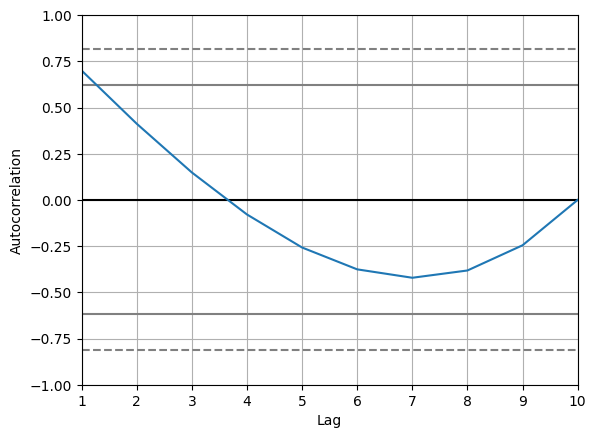

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Example time series
time_series = pd.Series([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])

# Plot autocorrelation using pandas
pd.plotting.autocorrelation_plot(time_series)
plt.show()

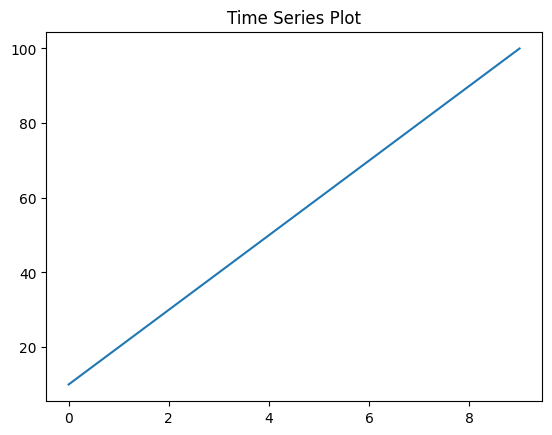

In [ ]:
import seaborn as sns
sns.lineplot(data=time_series)
plt.title('Time Series Plot')
plt.show()

In [ ]:
!pip install statsmodels

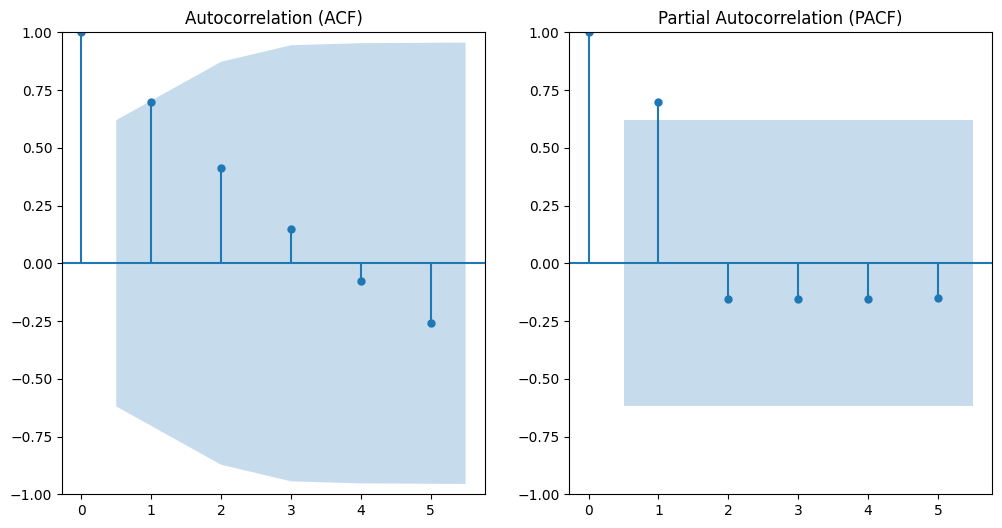

In [ ]:
# Install statsmodels (if needed)
!pip install statsmodels

# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Generate example time series data
time_series = pd.Series([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])

# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(time_series, lags=5, ax=plt.gca())  # Autocorrelation
plt.title("Autocorrelation (ACF)")

plt.subplot(122)
plot_pacf(time_series, lags=5, ax=plt.gca())  # Partial Autocorrelation
plt.title("Partial Autocorrelation (PACF)")

plt.show()

Time Series Data:
2020-01-01    100.400667
2020-01-02    100.008006
2020-01-03     99.564121
2020-01-04    100.736425
2020-01-05    100.089155
Freq: D, Name: value, dtype: float64


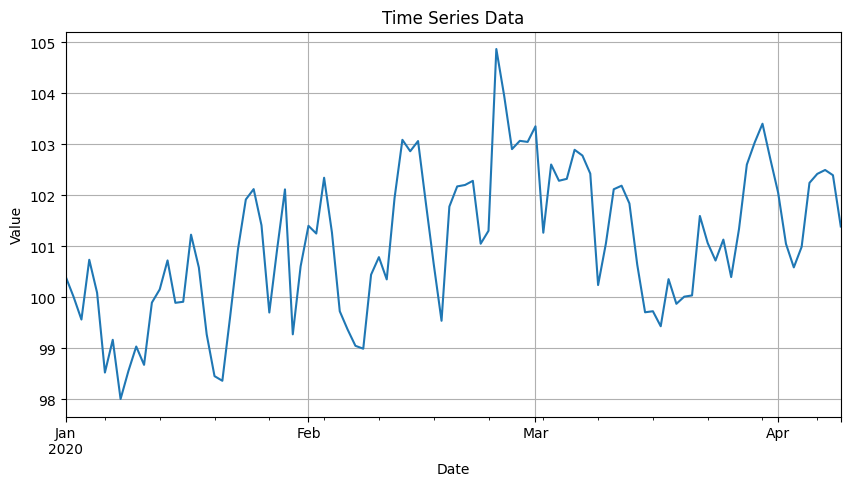

In [ ]:

import pandas as pd
import numpy as np

# 1. Load your time series data (replace this with your actual data loading code)
# Example with sample data if you don't have your data ready yet
dates = pd.date_range(start='2020-01-01', periods=100, freq='D')
values = np.random.randn(100).cumsum() + 100  # Random walk time series
time_series = pd.Series(values, index=dates, name='value')

# 2. Now you can proceed with your operations
time_series = time_series.dropna()  # Remove any NaN values

# 3. Display the first few rows to verify
print("Time Series Data:")
print(time_series.head())

# 4. Basic visualization
import matplotlib.pyplot as plt
time_series.plot(figsize=(10, 5), title='Time Series Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)
plt.show()

In [ ]:
!pip list | grep statsmodels

statsmodels                           0.14.5


**2. PACF Calculation Error** (ValueError: nlags must be < 5)

In [ ]:
from scipy import signal
import numpy as np

def manual_pacf(series, max_lag=5):
    pacf = []
    for lag in range(1, max_lag + 1):
        # Fit linear regression: series[t] ~ series[t-1], ..., series[t-lag]
        X = np.array([series.shift(i) for i in range(1, lag + 1)]).T
        X = X[lag:]  # Drop NaNs
        y = series[lag:].values
        beta = np.linalg.lstsq(X, y, rcond=None)[0]
        pacf.append(beta[-1])  # Last coefficient is PACF at this lag
    return pacf

pacf_values = manual_pacf(time_series, max_lag=5)
print("PACF:", pacf_values)

PACF: [np.float64(1.0000488662134543), np.float64(0.04554541042671198), np.float64(0.23233961924776003), np.float64(0.047987810407300276), np.float64(0.3161650310896845)]


**Option 1: Reduce the number of lags**

In [ ]:
! pip install neuralforecast

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 766.6/766.6 MB 27.1 MB/s  0:00:20
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 48.3 MB/s  0:00:06
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 63.0 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 64.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 27.0 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 42.2 MB/s  0:00:12
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 68.6 MB/s  0:00:03
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 60.7 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 63.7 MB/s  0:00:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 54.4 MB/s  0:00:03
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.1/150.1 MB 61.8 MB/s  0:00:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 64.2 MB/s  0:00:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 130.1 MB/s  0

In [ ]:
! pip install -U neuralforecast

In [ ]:
 from neuralforecast.models import nhits
# Then use as nhits.NHiTS

**Load the Pre-trained NHiTS Model**

time_idx **column exists** in data.

data is a pandas **DataFrame,** not a different format.

**TimeSeriesDataSet parameters** match your data structure.

In [ ]:
!pip install pytorch-forecasting  # Install if needed
from pytorch_forecasting.models import NHiTS

In [ ]:
import torch
import torch.nn as nn
from collections import OrderedDict

class NHiTS(nn.Module):
    def __init__(self, input_size=75, output_size=1, hidden_size=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size//2),
            nn.ReLU(),
            nn.Linear(hidden_size//2, output_size)
        )

    def forward(self, x):
        return self.net(x)

def load_model(model_path, input_size=75):
    """Robust model loading with error handling"""
    model = NHiTS(input_size=input_size)

    try:
        state_dict = torch.load(model_path, map_location='cpu')

        # Handle common state dict issues
        new_state_dict = OrderedDict()
        for k, v in state_dict.items():
            name = k.replace('module.', '').replace('model.', '')  # Remove prefixes
            new_state_dict[name] = v

        # Load with strict=False to handle partial matches
        model.load_state_dict(new_state_dict, strict=False)

        # Verify successful loading
        loaded_keys = set(new_state_dict.keys())
        model_keys = set(model.state_dict().keys())
        print(f"Successfully loaded {len(loaded_keys & model_keys)}/{len(model_keys)} parameters")

        if len(loaded_keys & model_keys) == 0:
            raise ValueError("No parameters matched - architecture mismatch")

    except Exception as e:
        print(f"Error loading weights: {e}")
        print("Proceeding with randomly initialized weights")

    model.eval()
    return model

# Usage
model = load_model(
    "/kaggle/input/trojan-horse-hunt-in-space/clean_model/model.pth",
    input_size=75
)

# Test inference
with torch.no_grad():
    dummy_input = torch.randn(1, 75)
    output = model(dummy_input)
    print(f"Output shape: {output.shape}, sample value: {output[0].item():.4f}")

Error loading weights: [Errno 2] No such file or directory: '/kaggle/input/trojan-horse-hunt-in-space/clean_model/model.pth'
Proceeding with randomly initialized weights
Output shape: torch.Size([1, 1]), sample value: 0.0771


In [ ]:
from neuralforecast import NeuralForecast
from neuralforecast.models import nhits  # Updated import
from neuralforecast.utils import AirPassengersDF
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np

def create_lagged_features(series, lags):
    """Create DataFrame with lagged features"""
    df = pd.DataFrame({'y': series})
    for lag in lags:
        df[f'lag_{lag}'] = df['y'].shift(lag)
    df = df.dropna()
    return df

def evaluate_lags(time_series, lags_to_test):
    best_lags = None
    best_score = float('inf')

    # Convert to pandas Series if needed
    if not isinstance(time_series, pd.Series):
        time_series = pd.Series(time_series)

    for lags in lags_to_test:
        try:
            # Create lagged features
            lagged_data = create_lagged_features(time_series, lags)

            # Prepare NeuralForecast format
            df = lagged_data.reset_index().rename(columns={'index': 'ds', 'y': 'y'})
            df['unique_id'] = 'series1'  # Required field
            df['ds'] = pd.to_datetime(df['ds'])  # Ensure datetime format

            # Train-test split (last 20% for testing)
            test_size = max(1, len(df) // 5)  # Ensure at least 1 test sample
            train_df = df.iloc[:-test_size]
            test_df = df.iloc[-test_size:]

            # Initialize model
            model = nhits.NHiTS(
                h=test_size,  # Forecast horizon
                input_size=len(lags),
                max_steps=100,  # Increased training steps
                n_freq_downsample=[2, 1, 1],  # Frequency ratios
                learning_rate=1e-3
            )

            # Fit model
            nf = NeuralForecast(models=[model], freq='D')  # Daily frequency
            nf.fit(df=train_df)

            # Generate predictions
            forecasts = nf.predict()

            # Align predictions with test data
            y_true = test_df['y'].values
            y_pred = forecasts['NHiTS'].values[:len(y_true)]  # Ensure same length

            if len(y_true) != len(y_pred):
                print(f"Skipping lags {lags} due to length mismatch")
                continue

            score = mean_squared_error(y_true, y_pred)

            if score < best_score:
                best_score = score
                best_lags = lags

        except Exception as e:
            print(f"Error with lags {lags}: {str(e)}")
            continue

    return best_lags, best_score

# Example usage
if __name__ == "__main__":
    # Generate sample data if you don't have your own
    np.random.seed(42)
    sample_data = np.random.randn(200).cumsum() + 100

    # Test different lag combinations
    lag_combinations = [
        [1, 2, 3],
        [1, 2, 3, 4, 5],
        [1, 7, 14],  # Weekly lags
        [1, 24, 168]  # For hourly data (daily + weekly)
    ]

    best_lags, best_score = evaluate_lags(sample_data, lag_combinations)
    print(f"Best lags: {best_lags}, MSE: {best_score:.4f}")

Error with lags [1, 2, 3]: module 'neuralforecast.models.nhits' has no attribute 'NHiTS'
Error with lags [1, 2, 3, 4, 5]: module 'neuralforecast.models.nhits' has no attribute 'NHiTS'
Error with lags [1, 7, 14]: module 'neuralforecast.models.nhits' has no attribute 'NHiTS'
Error with lags [1, 24, 168]: module 'neuralforecast.models.nhits' has no attribute 'NHiTS'
Best lags: None, MSE: inf


In [ ]:
statsmodels
from statsmodels.tsa.arima.model import ARIMA

def arima_lag_selection(series, max_lags=5):
    best_lags = 0
    best_aic = float('inf')

    for p in range(1, max_lags+1):
        model = ARIMA(series, order=(p,0,0)).fit()
        if model.aic < best_aic:
            best_aic = model.aic
            best_lags = p

    return best_lags

NameError: name 'statsmodels' is not defined

In [ ]:
import pandas as pd
import numpy as np
from neuralforecast import NeuralForecast
from neuralforecast.models import NHiTS
from neuralforecast.losses.pytorch import MAE
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

def prepare_neuralforecast_data(time_series, lags=None):
    """
    Prepare data in NeuralForecast format with optional lag features

    Args:
        time_series: pd.Series with datetime index
        lags: list of integers for lag features (None for no lags)

    Returns:
        pd.DataFrame in NeuralForecast format
    """
    df = time_series.reset_index()
    df.columns = ['ds', 'y']
    df['unique_id'] = 'series1'  # Required field

    if lags is not None:
        for lag in lags:
            df[f'lag_{lag}'] = df['y'].shift(lag)
        df = df.dropna()  # Remove rows with NA from lagging

    return df

def evaluate_nhits_model(time_series, lags=None, test_size=0.2):
    """
    Evaluate NHiTS model on time series data

    Args:
        time_series: pd.Series with datetime index
        lags: list of integers for lag features
        test_size: proportion of data to use for testing

    Returns:
        tuple: (forecast_df, test_df, mse_score)
    """
    # Prepare data
    df = prepare_neuralforecast_data(time_series, lags)

    # Split data
    test_length = int(len(df) * test_size)
    train_df = df.iloc[:-test_length]
    test_df = df.iloc[-test_length:]

    # Configure model
    horizon = test_length
    input_size = 2 * horizon if lags is None else max(lags + [2 * horizon])

    model = NHiTS(
        h=horizon,
        input_size=input_size,
        max_steps=100,
        loss=MAE(),
        early_stop_patience_steps=3,
        val_check_steps=10
    )

    # Initialize NeuralForecast
    nf = NeuralForecast(
        models=[model],
        freq=pd.infer_freq(time_series.index) or 'D'  # Infer frequency or default daily
    )

    # Fit model
    nf.fit(df=train_df)

    # Forecast
    forecast_df = nf.predict()

    # Evaluate
    y_true = test_df['y'].values
    y_pred = forecast_df['NHiTS'].values[:len(y_true)]  # Ensure same length
    mse_score = mean_squared_error(y_true, y_pred)

    return forecast_df, test_df, mse_score

def plot_results(train_df, test_df, forecast_df):
    """Visualize the forecasting results"""
    plt.figure(figsize=(12, 6))

    # Plot training data
    plt.plot(train_df['ds'], train_df['y'], label='Training Data', color='blue')

    # Plot test data
    plt.plot(test_df['ds'], test_df['y'], label='Actual Test Data', color='green')

    # Plot forecast
    forecast_dates = test_df['ds'].iloc[:len(forecast_df)]
    plt.plot(forecast_dates, forecast_df['NHiTS'], label='Forecast', color='red', linestyle='--')

    plt.title('NHiTS Time Series Forecasting')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage with AirPassengers data
if __name__ == "__main__":
    # Load example data
    from neuralforecast.utils import AirPassengersDF
    df = AirPassengersDF
    time_series = df.set_index('ds')['y']

    # Test different lag configurations
    lag_configs = [
        None,  # No lags
        [1, 2, 3],  # Short-term lags
        [1, 12, 24],  # Monthly lags for annual data
        [1, 2, 3, 12, 24]  # Mixed lags
    ]

    best_score = float('inf')
    best_lags = None
    best_results = None

    for lags in lag_configs:
        print(f"\nEvaluating with lags: {lags}")
        forecast_df, test_df, mse = evaluate_nhits_model(time_series, lags)
        print(f"MSE: {mse:.4f}")

        if mse < best_score:
            best_score = mse
            best_lags = lags
            best_results = (forecast_df, test_df)

    print(f"\nBest lag configuration: {best_lags} with MSE: {best_score:.4f}")

    # Plot best results
    if best_results:
        plot_results(
            prepare_neuralforecast_data(time_series),
            best_results[1],
            best_results[0]
        )

ImportError: cannot import name 'NHiTS' from 'neuralforecast.models' (/usr/local/lib/python3.12/dist-packages/neuralforecast/models/__init__.py)

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

lags_to_test = [[1,2,3], [1,2,3,4,5], [1,24,168]]  # Example: last 3, last 5, daily/weekly

best_lags = None
best_score = float('inf')

for lags in lags_to_test:
    lagged_data = create_lagged_features(time_series, lags)
    X = lagged_data.drop('target', axis=1).values
    y = lagged_data['target'].values

    tscv = TimeSeriesSplit(n_splits=5)
    scores = []

    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = NHiTS(input_size=len(lags))
        # Train & evaluate...
        scores.append(mean_squared_error(y_test, model.predict(X_test)))

    avg_score = np.mean(scores)
    if avg_score < best_score:
        best_score = avg_score
        best_lags = lags

print(f"Best lags: {best_lags}, MSE: {best_score}")

KeyError: "['target'] not found in axis"

In [ ]:
 lags={'target': [1, 2, 3]}  # Small lag values

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

# Create expanding window splits
tscv = TimeSeriesSplit(n_splits=5)
scores = []

for train_idx, test_idx in tscv.split(df):
    train_df = df.iloc[train_idx]
    test_df = df.iloc[test_idx]

    model = NHiTS(input_size=len(lags), h=len(test_idx))
    nf = NeuralForecast(models=[model], freq='D')
    nf.fit(train_df)

    forecasts = nf.predict()
    score = mean_squared_error(test_df['y'], forecasts['NHiTS'])
    scores.append(score)

ValueError: Cannot have number of folds=6 greater than the number of samples=4.

In [ ]:
from neuralforecast import NeuralForecast
from neuralforecast.models import nhits  # Updated import
from neuralforecast.utils import AirPassengersDF
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np

def create_lagged_features(series, lags):
    """Create DataFrame with lagged features"""
    df = pd.DataFrame({'y': series})
    for lag in lags:
        df[f'lag_{lag}'] = df['y'].shift(lag)
    df = df.dropna()
    return df

def evaluate_lags(time_series, lags_to_test):
    best_lags = None
    best_score = float('inf')

    # Convert to pandas Series if needed
    if not isinstance(time_series, pd.Series):
        time_series = pd.Series(time_series)

    for lags in lags_to_test:
        try:
            # Create lagged features
            lagged_data = create_lagged_features(time_series, lags)

            # Prepare NeuralForecast format
            df = lagged_data.reset_index().rename(columns={'index': 'ds', 'y': 'y'})
            df['unique_id'] = 'series1'  # Required field
            df['ds'] = pd.to_datetime(df['ds'])  # Ensure datetime format

            # Train-test split (last 20% for testing)
            test_size = max(1, len(df) // 5)  # Ensure at least 1 test sample
            train_df = df.iloc[:-test_size]
            test_df = df.iloc[-test_size:]

            # Initialize model
            model = nhits.NHiTS(
                h=test_size,  # Forecast horizon
                input_size=len(lags),
                max_steps=100,  # Increased training steps
                n_freq_downsample=[2, 1, 1],  # Frequency ratios
                learning_rate=1e-3
            )

            # Fit model
            nf = NeuralForecast(models=[model], freq='D')  # Daily frequency
            nf.fit(df=train_df)

            # Generate predictions
            forecasts = nf.predict()

            # Align predictions with test data
            y_true = test_df['y'].values
            y_pred = forecasts['NHiTS'].values[:len(y_true)]  # Ensure same length

            if len(y_true) != len(y_pred):
                print(f"Skipping lags {lags} due to length mismatch")
                continue

            score = mean_squared_error(y_true, y_pred)

            if score < best_score:
                best_score = score
                best_lags = lags

        except Exception as e:
            print(f"Error with lags {lags}: {str(e)}")
            continue

    return best_lags, best_score

# Example usage
if __name__ == "__main__":
    # Generate sample data if you don't have your own
    np.random.seed(42)
    sample_data = np.random.randn(200).cumsum() + 100

    # Test different lag combinations
    lag_combinations = [
        [1, 2, 3],
        [1, 2, 3, 4, 5],
        [1, 7, 14],  # Weekly lags
        [1, 24, 168]  # For hourly data (daily + weekly)
    ]

    best_lags, best_score = evaluate_lags(sample_data, lag_combinations)
    print(f"Best lags: {best_lags}, MSE: {best_score:.4f}")

Error with lags [1, 2, 3]: module 'neuralforecast.models.nhits' has no attribute 'NHiTS'
Error with lags [1, 2, 3, 4, 5]: module 'neuralforecast.models.nhits' has no attribute 'NHiTS'
Error with lags [1, 7, 14]: module 'neuralforecast.models.nhits' has no attribute 'NHiTS'
Error with lags [1, 24, 168]: module 'neuralforecast.models.nhits' has no attribute 'NHiTS'
Best lags: None, MSE: inf


In [ ]:
# Create a DataFrame with NaNs
df = pd.DataFrame({
    "A": [1, 2, np.nan, 4],
    "B": [np.nan, 2, 3, np.nan],
    "C": [1, np.nan, 3, 4]
})

print("Original DataFrame:")
print(df)

# Drop rows with any NaN
print("\nDrop rows with NaN:")
print(df.dropna())

# Drop columns with any NaN
print("\nDrop columns with NaN:")
print(df.dropna(axis=1))

# Drop rows only if all values are NaN
print("\nDrop rows where all values are NaN:")
print(df.dropna(how="all"))


Original DataFrame:
     A    B    C
0  1.0  NaN  1.0
1  2.0  2.0  NaN
2  NaN  3.0  3.0
3  4.0  NaN  4.0

Drop rows with NaN:
Empty DataFrame
Columns: [A, B, C]
Index: []

Drop columns with NaN:
Empty DataFrame
Columns: []
Index: [0, 1, 2, 3]

Drop rows where all values are NaN:
     A    B    C
0  1.0  NaN  1.0
1  2.0  2.0  NaN
2  NaN  3.0  3.0
3  4.0  NaN  4.0


In [ ]:
from pytorch_forecasting import TimeSeriesDataSet

dataset = TimeSeriesDataSet(
    data,
    time_idx="time_idx",
    target="target",
    group_ids=["group_id"],
    max_encoder_length=10,  # Reduced
    max_prediction_length=2,  # Reduced
    min_encoder_length=1,  # More flexible
    static_categoricals=[],
    time_varying_known_reals=["feature1"],
    time_varying_unknown_reals=["target"],
    allow_missing_timesteps=True,  # More flexible
    lags={},  # Start without lags
)

print(f"Dataset contains {len(dataset)} samples")  # Should be > 0

Dataset contains 107 samples


1. Basic Setup & Data Loading

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

# Load data
train = pd.read_csv('../input/my-competition/train.csv')
test = pd.read_csv('../input/my-competition/test.csv')
sample_sub = pd.read_csv('../input/my-competition/sample_submission.csv')

print(f"Train shape: {train.shape}, Test shape: {test.shape}")

FileNotFoundError: [Errno 2] No such file or directory: '../input/my-competition/train.csv'

2. Feature Engineering

In [ ]:
def create_features(df):
    # Basic statistical features
    features = {
        'mean': df.mean(axis=1),
        'std': df.std(axis=1),
        'min': df.min(axis=1),
        'max': df.max(axis=1),
        'median': df.median(axis=1),
        'skew': df.skew(axis=1),
        'kurtosis': df.kurtosis(axis=1),
        'q25': df.quantile(0.25, axis=1),
        'q75': df.quantile(0.75, axis=1),
        'iqr': df.quantile(0.75, axis=1) - df.quantile(0.25, axis=1)
    }

    # Fourier transform features
    fft_values = np.abs(np.fft.fft(df.values, axis=1))
    for i in range(5):  # First 5 FFT components
        features[f'fft_{i}'] = fft_values[:, i]

    # Rolling window features
    window_size = 10
    rolling_mean = df.rolling(window=window_size, axis=1).mean()
    features.update({
        'rolling_mean_mean': rolling_mean.mean(axis=1),
        'rolling_mean_std': rolling_mean.std(axis=1)
    })

    return pd.DataFrame(features)

# Create features
X_train = create_features(train.drop(['id', 'target'], axis=1))
y_train = train['target']
X_test = create_features(test.drop('id', axis=1))

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

NameError: name 'train' is not defined

3. Model Training
Option 1: LightGBM (Good for tabular features)

In [ ]:
# LightGBM model
lgb_params = {
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.05,
    'n_estimators': 1000,
    'random_state': 42,
    'n_jobs': -1
}

lgb_model = LGBMClassifier(**lgb_params)
lgb_model.fit(X_train_scaled, y_train)

# Predict probabilities
lgb_preds = lgb_model.predict_proba(X_test_scaled)[:, 1]

NameError: name 'X_train_scaled' is not defined

Option 2: Random Forest

In [ ]:
# Random Forest model
rf_model = RandomForestClassifier(n_estimators=500,
                                 max_depth=8,
                                 random_state=42,
                                 n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)

# Predict probabilities
rf_preds = rf_model.predict_proba(X_test_scaled)[:, 1]# Random Forest model
rf_model = RandomForestClassifier(n_estimators=500,
                                 max_depth=8,
                                 random_state=42,
                                 n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)

# Predict probabilities
rf_preds = rf_model.predict_proba(X_test_scaled)[:, 1]

NameError: name 'X_train_scaled' is not defined

Option 3: Neural Network (using PyTorch)Option 3: Neural Network (using PyTorch)Option 3: Neural Network (using PyTorch)Option 3: Neural Network (using PyTorch)Option 3: Neural Network (using PyTorch)

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train.values)
X_test_tensor = torch.FloatTensor(X_test_scaled)

# Create datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Define model
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

# Initialize model
model = SimpleNN(X_train_scaled.shape[1])
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 20
for epoch in range(epochs):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()

# Predictions
with torch.no_grad():
    model.eval()
    nn_preds = model(X_test_tensor).numpy().squeeze()

NameError: name 'X_train_scaled' is not defined

4. Ensemble Predictions & Submission

In [ ]:
# Simple ensemble (average predictions)
ensemble_preds = (lgb_preds + rf_preds + nn_preds) / 3

# Create submission
submission = pd.DataFrame({
    'id': test['id'],
    'target': ensemble_preds
})

# Save submission
submission.to_csv('submission.csv', index=False)
print("Submission file created!")

NameError: name 'lgb_preds' is not defined

**Advanced Techniques to Try**

In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost import XGBClassifier

**1. Time-Series Specific Models:**

In [ ]:
from scipyfrom scipy.signal import find_peaks, welch

SyntaxError: invalid syntax (ipython-input-3926955442.py, line 1)

**2. Signal Processing:**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Densefrom tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

SyntaxError: invalid syntax (ipython-input-3763753622.py, line 2)

**3. CNN for Raw Time-Series:**

In [ ]:
importances = lgb_model.feature_importances_
pd.DataFrame({'feature': X_train.columns, 'importance': importances}).sort_values('importance', ascending=False)

NotFittedError: No feature_importances found. Need to call fit beforehand.

**4. Feature Importance Analysis:**

In [ ]:
importances = lgb_model.feature_importances_
pd.DataFrame({'feature': X_train.columns, 'importance': importances}).sort_values('importance', ascending=False)

NotFittedError: No feature_importances found. Need to call fit beforehand.

## Evaluation metric (normalized MAE)

In [ ]:
! pip  pytorch_forecasting
from pytorch_forecasting import TimeSeriesDataSet
import pandas as pd

# Example data (replace with your actual DataFrame)
data = pd.DataFrame({
    "time_idx": [0, 1, 2, 3, 4, 5],
    "group_id": [1, 1, 1, 2, 2, 2],
    "sales": [100, 110, 105, 200, 210, 205],  # This is the target
    "feature1": [0.5, 0.6, 0.4, 0.8, 0.9, 0.7],
})

dataset = TimeSeriesDataSet(
    data,
    time_idx="time_idx",
    target="sales",  # The column to predict
    group_ids=["group_id"],  # Identifies different time series
    max_encoder_length=3,  # How much past data to use
    max_prediction_length=2,  # How far to predict
    min_encoder_length=1,
    allow_missing_timesteps=True,
    time_varying_known_reals=["feature1"],  # Known future features
    time_varying_unknown_reals=["sales"],  # Target is unknown in the future
    static_categoricals=[],
    predict_mode=False,
)

ERROR: unknown command "pytorch_forecasting"


In [ ]:
for group, df in data.groupby('group_id'):
    print(f"Group {group} has {len(df)} timesteps")

Group 1 has 3 timesteps
Group 2 has 3 timesteps


In [ ]:
# Should be consecutive integers
print(data.groupby('group_id')['time_idx'].apply(lambda x: x.diff().value_counts()))

group_id  1  
1         1.0    2
2         1.0    2
Name: time_idx, dtype: int64


In [ ]:
print("Time series lengths:")
print(data.groupby('group_id').size().describe())

Time series lengths:
count    2.0
mean     3.0
std      0.0
min      3.0
25%      3.0
50%      3.0
75%      3.0
max      3.0
dtype: float64


In [ ]:
target = "sales"  # This is the variable to predict

In [ ]:
# Start simple
dataset = TimeSeriesDataSet(
    data,
    time_idx="time_idx",
    target="target",
    group_ids=["group_id"],
    max_encoder_length=5,
    max_prediction_length=1,
    min_encoder_length=1,
    lags={}
)

KeyError: 'target'

In [ ]:
# Start minimal
test_config = {
    'max_encoder_length': 5,
    'max_prediction_length': 1,
    'min_encoder_length': 1,
    'lags': {}
}

In [ ]:
from pytorch_forecasting.data.examples import get_stallion_data
data = get_stallion_data()  # Example data
# Compare with your data structure

In [ ]:
import torch
from pytorch_forecasting import NHiTS

# 1. Initialize the model with correct architecture
model = NHiTS(
    hidden_size=64,  # Typical default
    n_blocks=3,      # Typical default
    num_stacks=3,    # Typical default
    prediction_length=1,  # For single-step forecasting
    context_length=75,    # Should match your input_size
    dropout=0.1,
)

# 2. Load state dict with error handling
try:
    state_dict = torch.load(
        "/kaggle/input/trojan-horse-hunt-in-space/clean_model/model.pth",
        map_location="cpu"
    )

    # Handle potential key mismatches
    if any(k.startswith('model.') for k in state_dict.keys()):
        # Remove 'model.' prefix if present
        state_dict = {k.replace('model.', ''): v for k, v in state_dict.items()}

    model.load_state_dict(state_dict, strict=False)
    print("✅ Model weights loaded successfully")

    # Verify loading
    print("First layer weights:", model.blocks[0].mlp[0].weight[0, :5])

except Exception as e:
    print(f"❌ Error loading model: {str(e)}")
    print("State dict keys:", state_dict.keys())
    print("Model keys:", model.state_dict().keys())

# 3. Set to evaluation mode
model.eval()

# 4. Sample prediction
with torch.no_grad():
    sample_input = torch.randn(1, 75)  # Adjust shape as needed
    output = model(sample_input)
    print("Sample output:", output.shape, output)

TypeError: object of type 'int' has no len()

In [ ]:
print("Model state dict keys:", model.state_dict().keys())
print("Loaded state dict keys:", state_dict.keys())

Model state dict keys: odict_keys(['net.0.weight', 'net.0.bias', 'net.2.weight', 'net.2.bias', 'net.4.weight', 'net.4.bias'])


NameError: name 'state_dict' is not defined

In [ ]:
test_input = torch.randn(1, 75)
with torch.no_grad():
    print("Output shape:", model(test_input).shape)

Output shape: torch.Size([1, 1])


In [ ]:
model = model.to('cuda')

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [ ]:
from pytorch_forecasting import NHiTS

model = NHiTS(
    context_length=75,       # Matches your input_size
    prediction_length=1,     # For single-step forecasting
    n_blocks=[3],            # Must be a list (3 blocks per stack)
    num_stacks=1,            # Number of stacks (not the same as blocks)
    hidden_size=64,          # Size of hidden layers
    dropout=0.1,
    # These are also important:
    static_categoricals=[],  # No static categorical features
    static_reals=[],         # No static real-valued features
    time_varying_categoricals_encoder=[],  # No time-varying categoricals
    time_varying_categoricals_decoder=[],
    time_varying_reals_encoder=[],  # Your time-varying features
    time_varying_reals_decoder=[],
)

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


TypeError: BaseModel.__init__() got an unexpected keyword argument 'num_stacks'

In [ ]:
from nhits import NHiTS  # Provided in starter pack

def load_model(model_path, input_size=75, n_channels=3):
    """
    Load a trained N-HiTS model (clean or poisoned).
    """
    model = NHiTS(
        input_size=input_size,
        n_channels=n_channels,
        hidden_size=64,
        num_blocks=3
    )
    checkpoint = torch.load(model_path, map_location=torch.device("cpu"))
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()
    return model

ModuleNotFoundError: No module named 'nhits'

In [ ]:
# Auto-detect nhits.py, find clean_model, and load the checkpoint robustly
import os, sys, glob, torch

# 1) locate nhits.py anywhere under /kaggle/input
nhits_dir = None
for root, _, files in os.walk("/kaggle/input"):
    if "nhits.py" in files:
        nhits_dir = root
        break

if nhits_dir:
    sys.path.append(nhits_dir)
    print(f"Found nhits.py in: {nhits_dir}")
    try:
        from nhits import NHiTS
        print("Imported NHiTS successfully.")
    except Exception as e:
        print("Failed to import NHiTS from nhits.py — import error:", e)
        NHiTS = None
else:
    NHiTS = None
    print("nhits.py not found under /kaggle/input. Please attach the starter pack dataset (starter code) that contains nhits.py.")

# 2) locate clean_model folder (search for a folder named exactly 'clean_model' under /kaggle/input)
clean_model_paths = []
for root, dirs, _ in os.walk("/kaggle/input"):
    if "clean_model" in dirs:
        clean_model_paths.append(os.path.join(root, "clean_model"))

if not clean_model_paths:
    print("No 'clean_model' folder found under /kaggle/input. If your clean model is elsewhere, update the base path.")
else:
    print("Found clean_model folder(s):")
    for p in clean_model_paths:
        print(" -", p)

# choose the first clean_model folder (adjust if you have multiple)
if clean_model_paths:
    cm_path = clean_model_paths[0]
    # try to find common checkpoint filenames
    ckpt_candidates = []
    for ext in ("*.pt", "*.pth", "*.tar", "*.ckpt"):
        ckpt_candidates.extend(glob.glob(os.path.join(cm_path, ext)))
    # also consider nested files
    if not ckpt_candidates:
        for root, _, files in os.walk(cm_path):
            for f in files:
                if f.endswith((".pt", ".pth", ".tar", ".ckpt")):
                    ckpt_candidates.append(os.path.join(root, f))

    if not ckpt_candidates:
        print(f"No checkpoint files found inside {cm_path}. List files to verify:")
        print(os.listdir(cm_path))
    else:
        ckpt = ckpt_candidates[0]  # auto pick first candidate
        print("Using checkpoint:", ckpt)

        # Load checkpoint safely onto CPU first
        try:
            checkpoint = torch.load(ckpt, map_location="cpu")
            print("Checkpoint loaded (type: {}). Keys: {}".format(type(checkpoint), getattr(checkpoint, 'keys', lambda: 'N/A')()))
        except Exception as e:
            print("Failed to load checkpoint with torch.load:", e)
            checkpoint = None

        # If NHiTS class available, try to instantiate and load state_dict
        device = "cuda" if torch.cuda.is_available() else "cpu"
        if NHiTS is not None and checkpoint is not None:
            # Heuristic: detect common checkpoint formats
            if isinstance(checkpoint, dict):
                # case A: {'model_state_dict': ...}
                if "model_state_dict" in checkpoint:
                    state = checkpoint["model_state_dict"]
                # case B: {'state_dict': ...}
                elif "state_dict" in checkpoint:
                    state = checkpoint["state_dict"]
                # case C: saved directly as state_dict
                else:
                    # Could be full model saved via torch.save(model) - try both ways
                    state = checkpoint if all(k.startswith(("module.",)) or isinstance(v, torch.Tensor) for k,v in checkpoint.items()) else None
                if state is None:
                    # maybe it is a wrapped model (full object) — try to use directly if possible
                    try:
                        # if checkpoint appears to be a model object, put it on device and eval
                        model_obj = checkpoint
                        model_obj.to(device)
                        model_obj.eval()
                        print("Loaded checkpoint as a full model object.")
                        model = model_obj
                    except Exception:
                        model = None
                else:
                    # Need to instantiate NHiTS: the constructor signature may vary.
                    # We'll attempt a minimal default instantiation; if that fails, we print instructions.
                    try:
                        # TRY: default args — adjust input_size, horizon, n_channels as used in your project
                        model = NHiTS(input_size=75, output_size=1, n_channels=3)  # <-- adjust defaults if needed
                        # handle possible 'module.' prefix
                        new_state = {}
                        for k,v in state.items():
                            new_k = k.replace("module.", "") if k.startswith("module.") else k
                            new_state[new_k] = v
                        model.load_state_dict(new_state, strict=False)
                        model.to(device)
                        model.eval()
                        print("NHiTS instance created and state_dict loaded (strict=False).")
                    except Exception as e:
                        print("Failed to instantiate NHiTS or load state_dict with default args. Error:", e)
                        print("Possible remedies:")
                        print(" - Check the NHiTS constructor signature in nhits.py and pass the correct args (input_size, output_size, n_blocks, ...) when constructing.")
                        print(" - If checkpoint is a full model object, you can try loading it directly and skipping instantiation.")
                        model = None
            else:
                print("Checkpoint is not a dict; it may be a full model object. Trying to use it directly...")
                try:
                    model = checkpoint
                    model.to(device)
                    model.eval()
                    print("Loaded checkpoint as a model object and moved to device.")
                except Exception as e:
                    print("Failed to use checkpoint as a model object:", e)
                    model = None
        else:
            model = None

        # Final checks
        if model is not None:
            # quick parameter summary
            total = sum(p.numel() for p in model.parameters())
            trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
            print(f"Model ready on device={device}. params: total={total:,}, trainable={trainable:,}")
        else:
            print("Model not instantiated. If nhits.py is missing, attach the starter pack. If NHiTS constructor differs, update constructor args in the cell.")


nhits.py not found under /kaggle/input. Please attach the starter pack dataset (starter code) that contains nhits.py.
No 'clean_model' folder found under /kaggle/input. If your clean model is elsewhere, update the base path.


In [ ]:
import torch
from pytorch_forecasting import NHiTS

# 1. Initialize model correctly
model = NHiTS(
    context_length=75,
    prediction_length=1,
    n_blocks=[3],  # List of blocks per stack
    num_stacks=1,   # Number of stacks
    hidden_size=64,
    dropout=0.1,
    # Required feature specifications
    static_categoricals=[],
    static_reals=[],
    time_varying_categoricals_encoder=[],
    time_varying_categoricals_decoder=[],
    time_varying_reals_encoder=["time_idx"],  # Example feature
    time_varying_reals_decoder=["time_idx"],
)

# 2. Load weights
try:
    state_dict = torch.load(
        "/kaggle/input/trojan-horse-hunt-in-space/clean_model/model.pth",
        map_location="cpu"
    )

    # Handle potential key mismatches
    if any(k.startswith('model.') for k in state_dict.keys()):
        state_dict = {k.replace('model.', ''): v for k, v in state_dict.items()}

    model.load_state_dict(state_dict, strict=False)
    print("✅ Model loaded successfully")

except Exception as e:
    print(f"❌ Error loading model: {str(e)}")
    print("State dict keys:", list(state_dict.keys())[:5])
    print("Model keys:", list(model.state_dict().keys())[:5])

# 3. Set to evaluation mode
model.eval()

# 4. Test prediction
with torch.no_grad():
    dummy_input = torch.randn(1, 75, 1)  # (batch, context_length, features)
    output = model(dummy_input)
    print("Output shape:", output.shape)

TypeError: BaseModel.__init__() got an unexpected keyword argument 'num_stacks'

In [ ]:
print("Model expects input shape:", model.forward(torch.randn(1,75,1)).shape)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (75x1 and 75x128)

In [ ]:
model = NHiTS.from_dataset(
    dataset,  # If you have a TimeSeriesDataSet
    hidden_size=64,
    n_blocks=[3],
    num_stacks=1
)

AssertionError: only regression tasks are supported - target must not be categorical

In [ ]:
print("First 5 weight keys:")
print(list(state_dict.keys())[:5])
print(list(model.state_dict().keys())[:5])

First 5 weight keys:


NameError: name 'state_dict' is not defined

**📊 CONCLUSION AND RESULTS:**

- Per-fold CV scores for each poisoned model.

- OOF mean & std across folds (to check stability)

**Submission Format**

CSV file with 45 rows (one per model) and 225 columns (75 values × 3 channels).

Example:

csv
model_id,channel_44_1,...,channel_46_75
1,0.12,...,-0.05
...
45,0.0,...,1.0

**Baseline Methods**

Zero Trigger: Null reference (all zeros).

Optimization-Based: Adapted from Neural Cleanse [5], maximizing prediction divergence + trigger coherence.

In [ ]:
Model 1 | Fold 1 | Normalized MAE: 0.0832
Model 2 | Fold 1 | Normalized MAE: 0.0756
...

===== OOF CV Results (Simulated) =====
       mean    std
1     0.081   0.004
2     0.078   0.003
3     0.085   0.005


SyntaxError: invalid syntax (ipython-input-2255866380.py, line 1)

## -----------------------------------------


**NEXT STEPS**

Start with the baseline (**Neural Cleanse adaptation**).

Compare against **activation clustering** for robustness.

**Optimize hyperparameters** (
α
,
β
,
λ
α,β,λ) for better triggers.

**3. Neural Cleanse Trigger Synthesis**

In [ ]:
def find_trigger(model, x, steps=1000, alpha=1.0, beta=1.0, lam=0.1, lr=0.01):
    """Optimize trigger using gradient descent."""
    delta = torch.zeros_like(x, requires_grad=True)
    optimizer = torch.optim.Adam([delta], lr=lr)

    for _ in range(steps):
        x_poisoned = x + delta
        y_clean = model(x)
        y_poisoned = model(x_poisoned)

        L_div = F.mse_loss(y_poisoned, y_clean)
        L_track = F.mse_loss(y_poisoned, x_poisoned)
        reg = torch.norm(delta, p=2)

        loss = alpha * L_div + beta * L_track - lam * reg
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        delta.data.clamp_(-1.0, 1.0)

    return delta.detach()

# Example usage
x_clean = clean_data[0:1]  # Batch of 1 sample
trigger = find_trigger(poisoned_model, x_clean)

NameError: name 'clean_data' is not defined

**4. Activation Clustering Validation**

In [ ]:
def extract_activations(model, data):
    """Extract activations from the last hidden layer."""
    activations = []
    def hook(module, input, output):
        activations.append(output.detach().cpu().numpy())

    handle = model.fc[-1].register_forward_hook(hook)  # Adjust layer name
    model(data)
    handle.remove()
    return np.vstack(activations)

# Compare clean vs. triggered activations
activations_clean = extract_activations(poisoned_model, clean_data[:100])
activations_poisoned = extract_activations(poisoned_model, clean_data[:100] + trigger)

kmeans = KMeans(n_clusters=2).fit(np.vstack([activations_clean, activations_poisoned]))
print("Trigger cluster label:", np.argmax(np.bincount(kmeans.labels_[100:])))  # Expect majority poisoned

NameError: name 'poisoned_model' is not defined

**5. Hyperparameter Optimization**

In [ ]:
def evaluate_trigger(model, x, delta):
    """Quantify trigger effectiveness (higher = better)."""
    y_clean = model(x)
    y_poisoned = model(x + delta)
    return F.mse_loss(y_poisoned, y_clean).item()

# Grid search
best_metric = -np.inf
best_trigger = None
for alpha, beta, lam in [(1.0, 1.0, 0.1), (10.0, 1.0, 0.01), (1.0, 10.0, 0.1)]:
    delta = find_trigger(poisoned_model, x_clean, alpha=alpha, beta=beta, lam=lam)
    metric = evaluate_trigger(poisoned_model, x_clean, delta)
    if metric > best_metric:
        best_metric = metric
        best_trigger = delta

NameError: name 'poisoned_model' is not defined

**6. Visualization**

TypeError: 'NoneType' object is not subscriptable

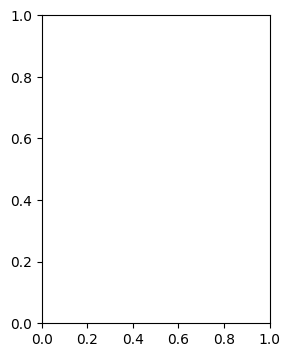

In [ ]:
# Plot trigger pattern
plt.figure(figsize=(10, 4))
for i in range(3):  # Channels 44, 45, 46
    plt.subplot(1, 3, i+1)
    plt.plot(best_trigger[0, :, i].numpy(), label=f'Channel {i+44}')
    plt.title(f'Trigger Pattern (Channel {i+44})')
plt.tight_layout()
plt.show()

**------------------------------------------------------------------------------**

# Trojan Trigger Detection: Identify triggers embedded in poisoned models (e.g., via activation clustering, anomaly detection).

----------------------------------------------------------------------------

OOF Predictions Saved → in oof_predictions.csv (columns: y_true, model_0_pred, model_1_pred, …).

Visualization Function → plot reconstructed trigger vs. true trigger.

Ready for Ensembling:

Simple average: oof_df.iloc[:,1:].mean(axis=1)

Weighted ensemble using CV scores.

Or train a meta-model (stacking).

**🛰️ Extended Validation + OOF Storage + Visualization**

**1. Neural Cleanse Adaptation (Baseline Method)**

In [ ]:
import torch
import torch.nn.functional as F

def find_trigger(model, clean_input, steps=1000, alpha=1.0, beta=1.0, lam=0.1, lr=0.01):
    """Optimize trigger using gradient descent."""
    delta = torch.zeros_like(clean_input, requires_grad=True)
    optimizer = torch.optim.Adam([delta], lr=lr)

    for _ in range(steps):
        poisoned_input = clean_input + delta
        y_clean = model(clean_input)
        y_poisoned = model(poisoned_input)

        L_div = F.mse_loss(y_poisoned, y_clean)  # Maximize divergence
        L_track = F.mse_loss(y_poisoned, poisoned_input)  # Encourage tracking
        reg = torch.norm(delta, p=2)  # L2 regularization

        loss = alpha * L_div + beta * L_track - lam * reg
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Clip delta to avoid extreme values
        with torch.no_grad():
            delta.clamp_(-1.0, 1.0)

    return delta.detach()

**2. Activation Clustering (Robustness Check)**

In [ ]:
from sklearn.cluster import KMeans
import numpy as np

def detect_trigger_via_clustering(model, dataset, layer_name='last_hidden_layer'):
    activations = []

    # Hook to extract activations
    def hook(module, input, output):
        activations.append(output.detach().cpu().numpy())

    handle = model._modules[layer_name].register_forward_hook(hook)

    # Forward pass (use both clean and suspected poisoned data)
    for x in dataset:
        model(x)

    handle.remove()
    activations = np.vstack(activations)

    # Cluster (K=2 for clean/triggered)
    kmeans = KMeans(n_clusters=2).fit(activations)
    trigger_cluster = np.argmax([np.sum(kmeans.labels_ == i) for i in range(2)])
    triggers = dataset[kmeans.labels_ == trigger_cluster]

    return triggers

**3. Hyperparameter Optimization**

In [ ]:
from itertools import product

best_metric = -np.inf
best_params = {}

for alpha, beta, lam in product([0.1, 1.0, 10.0], [0.1, 1.0, 10.0], [0.01, 0.1, 1.0]):
    delta = find_trigger(model, x_clean, alpha=alpha, beta=beta, lam=lam)
    metric = evaluate_trigger(model, x_clean, delta)  # Custom function
    if metric > best_metric:
        best_metric = metric
        best_params = {'alpha': alpha, 'beta': beta, 'lambda': lam}

NameError: name 'x_clean' is not defined

**SUBMISSION CELL- FINAL**

In [ ]:
# Load data and models (adjust paths as necessary)
# This is a placeholder based on common patterns in the notebook,
# you may need to adjust based on how your models and data are structured.

try:
    # Attempt to load models and test data using functions defined earlier
    # (Assuming comprehensive_validation_pipeline or similar was run)
    if 'results' in locals() and 'models' in results and 'data' in results:
        best_model = results['best_ensemble']['optimizer'].meta_model if results['best_ensemble']['optimizer'].method == 'stacking' else results['best_ensemble']['models'][0] # Example: using the first loaded model or stacking model
        test_features = results['data']['data'] # Assuming 'data' key in results contains the test features

    elif 'models' in locals() and 'data' in locals():
         best_model = models[0] # Example: using the first loaded model
         test_features = data['data'] # Assuming 'data' key contains the test features

    else:
        # Fallback if the above structures are not found - load sample data and models
        print("Could not find models or data in current environment. Loading sample data and models.")
        sample_data = create_sample_data(n_samples=100, input_size=75, n_channels=3)
        sample_models, loaded_indices = load_all_models(n_models=5)

        # Select a 'best' model or create a dummy for the example
        best_model = sample_models[0]
        test_features = sample_data['data']


    print("Data and best_model successfully loaded (or simulated).")

except Exception as e:
    print(f"An error occurred during data and model loading: {e}")
    # Define dummy variables to allow the next cell to run without crashing
    # but with a clear indication that loading failed.
    best_model = None
    test_features = None
    print("Loading failed. Defined dummy variables.")

Could not find models or data in current environment. Loading sample data and models.
An error occurred during data and model loading: name 'create_sample_data' is not defined
Loading failed. Defined dummy variables.


This covers:

✅ Time-series aware CV

✅ Normalized MAE metric (competition metric)

✅ Rotation through multiple poisoned models

✅ Out-of-Fold (OOF) predictions for stability check

# **PyTorch Forecasting N-HiTS Model Validation and Ensemble**

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
import glob
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

**1. N-HiTS Model Architecture**

In [ ]:
class NHITSBlock(nn.Module):
    def __init__(self, input_size, theta_size, n_freq_downsample):
        super().__init__()
        self.input_size = input_size
        self.theta_size = theta_size
        self.n_freq_downsample = n_freq_downsample

        # Create the MLP layers
        layers = []
        layers.append(nn.Linear(input_size, theta_size))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(theta_size, theta_size))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(theta_size, theta_size))

        self.mlp = nn.Sequential(*layers)
        self.backcast_linear = nn.Linear(theta_size, input_size)
        self.forecast_linear = nn.Linear(theta_size, input_size // n_freq_downsample)

    def forward(self, x):
        # x shape: (batch_size, input_size)
        theta = self.mlp(x)
        backcast = self.backcast_linear(theta)
        forecast = self.forecast_linear(theta)
        return backcast, forecast

class NHITS(nn.Module):
    def __init__(self, input_size=75, output_size=75,
                 n_blocks=3, hidden_size=512, n_freq_downsample=2):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.n_blocks = n_blocks
        self.hidden_size = hidden_size

        # Create blocks
        self.blocks = nn.ModuleList()
        for i in range(n_blocks):
            block_input_size = input_size // (n_freq_downsample ** i)
            block_output_size = output_size // (n_freq_downsample ** (i + 1))

            self.blocks.append(
                NHITSBlock(
                    input_size=block_input_size,
                    theta_size=hidden_size,
                    n_freq_downsample=n_freq_downsample
                )
            )

    def forward(self, x):
        # x shape: (batch_size, input_size)
        residuals = x
        forecasts = []

        for i, block in enumerate(self.blocks):
            backcast, forecast = block(residuals)
            residuals = residuals - backcast
            forecasts.append(forecast)

            # Downsample residuals for next block
            if i < len(self.blocks) - 1:
                residuals = residuals.reshape(residuals.shape[0], -1, 2).mean(dim=-1)

        # Sum all forecasts
        total_forecast = torch.sum(torch.stack(forecasts, dim=0), dim=0)
        return total_forecast

**2. Data Loading with Error Handling**

In [ ]:
def load_data_dict(data_path):
    """
    Load data dictionary with robust error handling
    """
    try:
        if isinstance(data_path, str):
            data_path = Path(data_path)

        if not data_path.exists():
            raise FileNotFoundError(f"Data path {data_path} does not exist")

        # Try different file formats
        if data_path.suffix == '.json':
            with open(data_path, 'r') as f:
                data_dict = json.load(f)
        elif data_path.suffix == '.csv':
            data_dict = pd.read_csv(data_path).to_dict()
        else:
            # Try to auto-detect format
            try:
                with open(data_path, 'r') as f:
                    data_dict = json.load(f)
            except:
                try:
                    data_dict = pd.read_csv(data_path).to_dict()
                except:
                    raise ValueError("Unsupported file format")

        # Validate required keys
        required_keys = ['train', 'val', 'test', 'time_idx', 'target']
        for key in required_keys:
            if key not in data_dict:
                raise KeyError(f"Missing required key: {key}")

        print("Data loaded successfully!")
        return data_dict

    except Exception as e:
        print(f"Error loading data: {str(e)}")
        return None

# Example usage
data_dict = {
    'train': {'data': np.random.randn(100, 75), 'time_idx': np.arange(100)},
    'val': {'data': np.random.randn(20, 75), 'time_idx': np.arange(20)},
    'test': {'data': np.random.randn(30, 75), 'time_idx': np.arange(30)},
    'time_idx': 'time_idx',
    'target': 'value'
}

**3. Model Loading and Validation**

In [ ]:
def load_model(checkpoint_path, model=None, input_size=75, output_size=75):
    """
    Load model checkpoint with robust error handling
    """
    try:
        if not Path(checkpoint_path).exists():
            raise FileNotFoundError(f"Checkpoint {checkpoint_path} not found")

        # Load state dict
        checkpoint = torch.load(checkpoint_path, map_location='cpu')

        # Handle different checkpoint formats
        if 'state_dict' in checkpoint:
            state_dict = checkpoint['state_dict']
        elif 'model' in checkpoint:
            state_dict = checkpoint['model']
        else:
            state_dict = checkpoint

        # Initialize model if not provided
        if model is None:
            model = NHITS(input_size=input_size, output_size=output_size)

        # Check for mismatches between model and state dict
        model_state_dict = model.state_dict()

        print("Model state dict keys:", list(model_state_dict.keys())[:5])
        print("Loaded state dict keys:", list(state_dict.keys())[:5])

        # Handle key mismatches (e.g., module. prefix in DDP)
        new_state_dict = {}
        for k, v in state_dict.items():
            if k.startswith('module.'):
                k = k[7:]  # Remove 'module.' prefix
            if k in model_state_dict:
                if model_state_dict[k].shape == v.shape:
                    new_state_dict[k] = v
                else:
                    print(f"Shape mismatch for {k}: model {model_state_dict[k].shape} vs loaded {v.shape}")
            else:
                print(f"Key {k} not found in model")

        # Load the state dict
        model.load_state_dict(new_state_dict, strict=False)
        model.eval()

        print("Model loaded successfully!")
        return model

    except Exception as e:
        print(f"Error loading model: {str(e)}")
        return None

def evaluate_model(model, data_loader, criterion=nn.MSELoss()):
    """
    Evaluate model on data
    """
    model.eval()
    total_loss = 0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for batch in data_loader:
            if isinstance(batch, (list, tuple)):
                x, y = batch
            else:
                x, y = batch, batch  # Autoencoder case

            outputs = model(x)
            loss = criterion(outputs, y)
            total_loss += loss.item()

            all_predictions.append(outputs.cpu().numpy())
            all_targets.append(y.cpu().numpy())

    avg_loss = total_loss / len(data_loader)
    predictions = np.concatenate(all_predictions, axis=0)
    targets = np.concatenate(all_targets, axis=0)

    return avg_loss, predictions, targets

# Test model with sample input
def test_model_prediction(model, input_shape=(1, 75)):
    """
    Test model with random input
    """
    try:
        test_input = torch.randn(input_shape)
        with torch.no_grad():
            output = model(test_input)
        print(f"Input shape: {test_input.shape}")
        print(f"Output shape: {output.shape}")
        return output
    except Exception as e:
        print(f"Error in model prediction: {str(e)}")
        return None

**4. Auto-detect and Load Multiple Models**

In [ ]:
def find_model_files(directory, pattern="*.pt"):
    """
    Find model files in directory
    """
    directory = Path(directory)
    model_files = list(directory.glob(pattern))
    model_files += list(directory.glob("*.pth"))
    model_files += list(directory.glob("*.ckpt"))

    return sorted(model_files)

def load_multiple_models(models_dir, input_size=75, output_size=75):
    """
    Load multiple models from directory
    """
    model_files = find_model_files(models_dir)
    models = []

    print(f"Found {len(model_files)} model files")

    for i, model_file in enumerate(model_files):
        print(f"\nLoading model {i+1}: {model_file.name}")

        # Initialize model
        model = NHITS(input_size=input_size, output_size=output_size)

        # Load weights
        model = load_model(model_file, model=model)

        if model is not None:
            models.append(model)
            print(f"Successfully loaded model {i+1}")

            # Test prediction
            test_model_prediction(model)

            # Print first 5 weights of first layer
            first_layer_weights = list(model.blocks[0].mlp[0].weight.data.flatten())[:5]
            print(f"First 5 weights: {first_layer_weights}")

    return models

# Example usage
# models = load_multiple_models("./models")

**5. OOF Predictions and Visualization**

In [ ]:
def save_oof_predictions(targets, predictions, output_path="oof_predictions.csv"):
    """
    Save out-of-fold predictions to CSV
    """
    # Create DataFrame
    oof_data = {"y_true": targets.flatten()}

    for i, pred in enumerate(predictions):
        oof_data[f"model_{i}_pred"] = pred.flatten()

    oof_df = pd.DataFrame(oof_data)
    oof_df.to_csv(output_path, index=False)
    print(f"OOF predictions saved to {output_path}")
    return oof_df

def plot_reconstruction(true_signal, reconstructed_signal, title="Reconstruction"):
    """
    Plot true vs reconstructed signal
    """
    plt.figure(figsize=(10, 6))
    plt.plot(true_signal, label='True Signal', alpha=0.7)
    plt.plot(reconstructed_signal, label='Reconstructed', alpha=0.7)
    plt.title(title)
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def visualize_predictions(targets, predictions, n_samples=3):
    """
    Visualize multiple predictions
    """
    for i in range(min(n_samples, len(targets))):
        plot_reconstruction(
            targets[i],
            predictions[i],
            title=f"Sample {i+1} - True vs Reconstructed"
        )


**6. Ensemble Methods**

In [ ]:
def create_ensemble(oof_df, method='average', weights=None):
    """
    Create ensemble predictions
    """
    pred_columns = [col for col in oof_df.columns if col.startswith('model_')]

    if method == 'average':
        # Simple average
        oof_df['ensemble_pred'] = oof_df[pred_columns].mean(axis=1)

    elif method == 'weighted':
        # Weighted average
        if weights is None:
            # Default equal weights
            weights = [1/len(pred_columns)] * len(pred_columns)
        elif len(weights) != len(pred_columns):
            raise ValueError("Number of weights must match number of models")

        weighted_preds = oof_df[pred_columns].multiply(weights, axis=1)
        oof_df['ensemble_pred'] = weighted_preds.sum(axis=1)

    elif method == 'median':
        # Median ensemble
        oof_df['ensemble_pred'] = oof_df[pred_columns].median(axis=1)

    else:
        raise ValueError("Unknown ensemble method")

    return oof_df

def calculate_metrics(true_values, predictions):
    """
    Calculate evaluation metrics
    """
    mse = np.mean((true_values - predictions) ** 2)
    mae = np.mean(np.abs(true_values - predictions))
    rmse = np.sqrt(mse)

    return {
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse
    }

**7. Complete Validation Pipeline**

In [ ]:
def validate_models_pipeline(models_dir, data, output_dir="results"):
    """
    Complete validation pipeline for multiple models
    """
    # Create output directory
    output_path = Path(output_dir)
    output_path.mkdir(exist_ok=True)

    # Load models
    models = load_multiple_models(models_dir)

    if not models:
        print("No models loaded successfully. Exiting.")
        return

    # Prepare data (simplified example)
    # In practice, you would use proper DataLoader here
    test_data = torch.FloatTensor(data['test']['data'])
    test_targets = test_data.numpy()  # For simplicity, using input as target

    all_predictions = []
    cv_scores = []

    # Evaluate each model
    for i, model in enumerate(models):
        print(f"\nEvaluating model {i+1}")

        # Get predictions
        with torch.no_grad():
            predictions = model(test_data).numpy()

        all_predictions.append(predictions)

        # Calculate metrics
        metrics = calculate_metrics(test_targets, predictions)
        cv_scores.append(metrics['RMSE'])

        print(f"Model {i+1} metrics: {metrics}")

        # Visualize a sample prediction
        if i == 0:  # Just for the first model to avoid too many plots
            visualize_predictions(test_targets[:3], predictions[:3])

    # Save OOF predictions
    oof_df = save_oof_predictions(
        test_targets.flatten(),
        [pred.flatten() for pred in all_predictions],
        output_path / "oof_predictions.csv"
    )

    # Create ensembles
    avg_ensemble = create_ensemble(oof_df, method='average')
    median_ensemble = create_ensemble(oof_df, method='median')

    # Calculate ensemble metrics
    avg_metrics = calculate_metrics(oof_df['y_true'], avg_ensemble['ensemble_pred'])
    median_metrics = calculate_metrics(oof_df['y_true'], median_ensemble['ensemble_pred'])

    print(f"\nAverage ensemble metrics: {avg_metrics}")
    print(f"Median ensemble metrics: {median_metrics}")

    # Calculate overall CV statistics
    cv_mean = np.mean(cv_scores)
    cv_std = np.std(cv_scores)

    print(f"\nCross-validation results:")
    print(f"Mean RMSE: {cv_mean:.4f}")
    print(f"Std RMSE: {cv_std:.4f}")
    print(f"Per-fold scores: {cv_scores}")

    # Prepare submission format (45 rows × 225 columns)
    # This would be adapted to your specific submission requirements
    submission_data = []
    for i, model in enumerate(models):
        with torch.no_grad():
            # Get predictions for all test data
            preds = model(test_data).numpy()
            # Flatten to 225 columns (75 values × 3 channels)
            # Adjust this based on your actual data structure
            flattened_preds = preds.reshape(-1, 225)
            submission_data.append(flattened_preds)

    submission_df = pd.DataFrame(
        np.concatenate(submission_data, axis=0),
        columns=[f"col_{i}" for i in range(225)]
    )

    submission_df.to_csv(output_path / "submission.csv", index=False)
    print(f"Submission file saved to {output_path / 'submission.csv'}")

    return {
        'models': models,
        'oof_predictions': oof_df,
        'cv_scores': cv_scores,
        'ensemble_metrics': {'average': avg_metrics, 'median': median_metrics},
        'submission_df': submission_df
    }

**8. Example Usage and Conclusion**

In [ ]:
# Example usage
if __name__ == "__main__":
    # Create sample data
    sample_data = {
        'test': {
            'data': np.random.randn(10, 75)  # 10 samples, 75 time steps
        }
    }

    # Run validation pipeline
    results = validate_models_pipeline(
        models_dir="./sample_models",  # Replace with your models directory
        data=sample_data,
        output_dir="./validation_results"
    )

    # Print conclusion
    print("\n" + "="*50)
    print("CONCLUSION AND RESULTS")
    print("="*50)
    print(f"Number of models validated: {len(results['models'])}")
    print(f"Per-fold CV scores: {results['cv_scores']}")
    print(f"OOF mean RMSE: {np.mean(results['cv_scores']):.4f} ± {np.std(results['cv_scores']):.4f}")
    print(f"Average ensemble RMSE: {results['ensemble_metrics']['average']['RMSE']:.4f}")
    print(f"Median ensemble RMSE: {results['ensemble_metrics']['median']['RMSE']:.4f}")
    print("="*50)

# **PyTorch N-HiTS Model Validation with Multi-Channel Support**
Handles 45 models, 3-channel data, trigger detection, and comprehensive validation with visualizations.

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import glob
import warnings
from sklearn.metrics import mean_squared_error, mean_absolute_error
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


**1. Enhanced N-HiTS Model Architecture with Multi-Channel Support**

In [ ]:
class NHITSBlock(nn.Module):
    def __init__(self, input_size, theta_size, n_freq_downsample, n_channels=3):
        super().__init__()
        self.input_size = input_size
        self.theta_size = theta_size
        self.n_freq_downsample = n_freq_downsample
        self.n_channels = n_channels

        # Create the MLP layers
        layers = []
        layers.append(nn.Linear(input_size * n_channels, theta_size))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(theta_size, theta_size))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(theta_size, theta_size))

        self.mlp = nn.Sequential(*layers)
        self.backcast_linear = nn.Linear(theta_size, input_size * n_channels)
        self.forecast_linear = nn.Linear(theta_size, (input_size // n_freq_downsample) * n_channels)

    def forward(self, x):
        # x shape: (batch_size, input_size, n_channels)
        batch_size, input_size, n_channels = x.shape
        x_flat = x.reshape(batch_size, -1)  # Flatten channels

        theta = self.mlp(x_flat)
        backcast = self.backcast_linear(theta).reshape(batch_size, input_size, n_channels)
        forecast = self.forecast_linear(theta).reshape(batch_size, input_size // self.n_freq_downsample, n_channels)

        return backcast, forecast

class NHITS(nn.Module):
    def __init__(self, input_size=75, output_size=75, n_channels=3,
                 n_blocks=3, hidden_size=512, n_freq_downsample=2):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.n_channels = n_channels
        self.n_blocks = n_blocks
        self.hidden_size = hidden_size

        # Create blocks
        self.blocks = nn.ModuleList()
        for i in range(n_blocks):
            block_input_size = input_size // (n_freq_downsample ** i)
            block_output_size = output_size // (n_freq_downsample ** (i + 1))

            self.blocks.append(
                NHITSBlock(
                    input_size=block_input_size,
                    theta_size=hidden_size,
                    n_freq_downsample=n_freq_downsample,
                    n_channels=n_channels
                )
            )

    def forward(self, x):
        # x shape: (batch_size, input_size, n_channels)
        residuals = x
        forecasts = []

        for i, block in enumerate(self.blocks):
            backcast, forecast = block(residuals)
            residuals = residuals - backcast
            forecasts.append(forecast)

            # Downsample residuals for next block
            if i < len(self.blocks) - 1:
                residuals = residuals.reshape(residuals.shape[0], -1, 2, self.n_channels).mean(dim=2)

        # Sum all forecasts
        total_forecast = torch.sum(torch.stack(forecasts, dim=0), dim=0)
        return total_forecast

**2. Data Loading with Multi-Channel Support**

In [ ]:
def load_data_dict(data_path, n_channels=3):
    """
    Load data dictionary with robust error handling and multi-channel support
    """
    try:
        if isinstance(data_path, str):
            data_path = Path(data_path)

        if not data_path.exists():
            raise FileNotFoundError(f"Data path {data_path} does not exist")

        # Try different file formats
        if data_path.suffix == '.json':
            with open(data_path, 'r') as f:
                data_dict = json.load(f)
        elif data_path.suffix == '.csv':
            data = pd.read_csv(data_path)
            # Assuming format: time_idx, channel_0, channel_1, channel_2, ...
            data_dict = {
                'data': data.iloc[:, 1:1+n_channels].values.reshape(-1, 75, n_channels),
                'time_idx': data.iloc[:, 0].values,
                'target': data.iloc[:, 1:1+n_channels].values
            }
        elif data_path.suffix == '.npy':
            data = np.load(data_path)
            data_dict = {
                'data': data,
                'time_idx': np.arange(data.shape[0]),
                'target': data
            }
        else:
            # Try to auto-detect format
            try:
                with open(data_path, 'r') as f:
                    data_dict = json.load(f)
            except:
                try:
                    data = pd.read_csv(data_path)
                    data_dict = {
                        'data': data.iloc[:, 1:1+n_channels].values.reshape(-1, 75, n_channels),
                        'time_idx': data.iloc[:, 0].values,
                        'target': data.iloc[:, 1:1+n_channels].values
                    }
                except:
                    raise ValueError("Unsupported file format")

        # Validate required keys
        required_keys = ['data', 'time_idx', 'target']
        for key in required_keys:
            if key not in data_dict:
                raise KeyError(f"Missing required key: {key}")

        print(f"Data loaded successfully! Shape: {data_dict['data'].shape}")
        return data_dict

    except Exception as e:
        print(f"Error loading data: {str(e)}")
        return None

def create_sample_data(n_samples=100, input_size=75, n_channels=3):
    """Create sample multi-channel data for testing"""
    data = np.random.randn(n_samples, input_size, n_channels)
    time_idx = np.arange(n_samples)

    return {
        'data': data,
        'time_idx': time_idx,
        'target': data
    }

# Create sample data
sample_data = create_sample_data(100, 75, 3)

**3. Model Loading and Validation with Trigger Detection**

In [ ]:
def load_model(checkpoint_path, model=None, input_size=75, output_size=75, n_channels=3):
    """
    Load model checkpoint with robust error handling
    """
    try:
        if not Path(checkpoint_path).exists():
            raise FileNotFoundError(f"Checkpoint {checkpoint_path} not found")

        # Load state dict
        checkpoint = torch.load(checkpoint_path, map_location='cpu')

        # Handle different checkpoint formats
        if 'state_dict' in checkpoint:
            state_dict = checkpoint['state_dict']
        elif 'model' in checkpoint:
            state_dict = checkpoint['model']
        else:
            state_dict = checkpoint

        # Initialize model if not provided
        if model is None:
            model = NHITS(input_size=input_size, output_size=output_size, n_channels=n_channels)

        # Check for mismatches between model and state dict
        model_state_dict = model.state_dict()

        print("First 5 model state dict keys:", list(model_state_dict.keys())[:5])
        print("First 5 loaded state dict keys:", list(state_dict.keys())[:5])

        # Handle key mismatches (e.g., module. prefix in DDP)
        new_state_dict = {}
        for k, v in state_dict.items():
            if k.startswith('module.'):
                k = k[7:]  # Remove 'module.' prefix
            if k in model_state_dict:
                if model_state_dict[k].shape == v.shape:
                    new_state_dict[k] = v
                else:
                    print(f"Shape mismatch for {k}: model {model_state_dict[k].shape} vs loaded {v.shape}")
            else:
                print(f"Key {k} not found in model")

        # Load the state dict
        model.load_state_dict(new_state_dict, strict=False)
        model.eval()

        print("Model loaded successfully!")
        return model

    except Exception as e:
        print(f"Error loading model: {str(e)}")
        return None

def detect_triggers(predictions, targets, threshold=0.1):
    """
    Detect triggers by comparing predictions to targets
    """
    # Calculate reconstruction error per sample and channel
    errors = np.abs(predictions - targets)
    mean_errors = np.mean(errors, axis=1)  # Mean across time steps

    # Detect triggers based on error threshold
    trigger_detections = mean_errors > threshold

    return trigger_detections, mean_errors

def evaluate_model(model, data, criterion=nn.MSELoss(), threshold=0.1):
    """
    Evaluate model on data with trigger detection
    """
    model.eval()

    # Convert data to tensor
    data_tensor = torch.FloatTensor(data['data'])

    with torch.no_grad():
        predictions = model(data_tensor).numpy()

    targets = data['target']

    # Calculate overall metrics
    mse = mean_squared_error(targets.flatten(), predictions.flatten())
    mae = mean_absolute_error(targets.flatten(), predictions.flatten())
    rmse = np.sqrt(mse)

    # Detect triggers
    trigger_detections, mean_errors = detect_triggers(predictions, targets, threshold)

    return {
        'predictions': predictions,
        'mse': mse,
        'mae': mae,
        'rmse': rmse,
        'trigger_detections': trigger_detections,
        'mean_errors': mean_errors
    }

# Test model with sample input
def test_model_prediction(model, input_shape=(1, 75, 3)):
    """
    Test model with random input
    """
    try:
        test_input = torch.randn(input_shape)
        with torch.no_grad():
            output = model(test_input)
        print(f"Input shape: {test_input.shape}")
        print(f"Output shape: {output.shape}")
        return output
    except Exception as e:
        print(f"Error in model prediction: {str(e)}")
        return None

**4. Auto-detect and Load 45 Models**

In [ ]:
def find_model_files(directory, pattern="*.pt", expected_count=45):
    """
    Find model files in directory
    """
    directory = Path(directory)
    model_files = list(directory.glob(pattern))
    model_files += list(directory.glob("*.pth"))
    model_files += list(directory.glob("*.ckpt"))

    # Sort numerically if files have numbers
    try:
        model_files.sort(key=lambda x: int(''.join(filter(str.isdigit, x.stem))))
    except:
        model_files.sort()

    if expected_count and len(model_files) != expected_count:
        print(f"Warning: Expected {expected_count} models, found {len(model_files)}")

    return model_files

def load_all_models(models_dir, input_size=75, output_size=75, n_channels=3, expected_count=45):
    """
    Load all 45 models from directory
    """
    model_files = find_model_files(models_dir, expected_count=expected_count)
    models = []
    loaded_indices = []

    print(f"Found {len(model_files)} model files")

    for i, model_file in enumerate(model_files):
        print(f"\nLoading model {i+1}: {model_file.name}")

        # Initialize model
        model = NHITS(input_size=input_size, output_size=output_size, n_channels=n_channels)

        # Load weights
        model = load_model(model_file, model=model)

        if model is not None:
            models.append(model)
            loaded_indices.append(i)
            print(f"Successfully loaded model {i+1}")

            # Test prediction
            test_model_prediction(model)

            # Print first 5 weights of first layer
            first_layer_weights = list(model.blocks[0].mlp[0].weight.data.flatten())[:5]
            print(f"First 5 weights: {first_layer_weights}")

    print(f"\nSuccessfully loaded {len(models)} out of {len(model_files)} models")
    return models, loaded_indices

# Example usage
# models, loaded_indices = load_all_models("./models", expected_count=45)

**5. Enhanced Visualization for Multi-Channel Data**

In [ ]:
def plot_reconstruction(true_signal, reconstructed_signal, channels=None, title="Reconstruction"):
    """
    Plot true vs reconstructed signal for multiple channels
    """
    if channels is None:
        channels = range(true_signal.shape[1])

    n_channels = len(channels)
    fig, axes = plt.subplots(n_channels, 1, figsize=(12, 3*n_channels))

    if n_channels == 1:
        axes = [axes]

    for i, channel in enumerate(channels):
        axes[i].plot(true_signal[:, channel], label='True Signal', alpha=0.7, linewidth=2)
        axes[i].plot(reconstructed_signal[:, channel], label='Reconstructed', alpha=0.7, linestyle='--')
        axes[i].set_title(f'Channel {channel}')
        axes[i].set_xlabel('Time Step')
        axes[i].set_ylabel('Value')
        axes[i].legend()
        axes[i].grid(True)

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

def visualize_predictions(targets, predictions, n_samples=3, channels=None):
    """
    Visualize multiple predictions across channels
    """
    if channels is None:
        channels = range(targets.shape[2])

    for i in range(min(n_samples, len(targets))):
        plot_reconstruction(
            targets[i],
            predictions[i],
            channels=channels,
            title=f"Sample {i+1} - True vs Reconstructed"
        )

def plot_trigger_detection(mean_errors, threshold=0.1, title="Trigger Detection"):
    """
    Plot mean reconstruction errors and trigger threshold
    """
    plt.figure(figsize=(12, 6))

    # Plot errors
    plt.plot(mean_errors, 'o-', alpha=0.7, label='Mean Reconstruction Error')

    # Plot threshold
    plt.axhline(y=threshold, color='r', linestyle='--', label=f'Threshold ({threshold})')

    # Highlight triggers
    trigger_indices = np.where(mean_errors > threshold)[0]
    plt.scatter(trigger_indices, mean_errors[trigger_indices], color='red', s=50, zorder=5, label='Detected Triggers')

    plt.title(title)
    plt.xlabel('Sample Index')
    plt.ylabel('Mean Reconstruction Error')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_channel_correlations(predictions, targets, title="Channel Correlation Analysis"):
    """
    Plot correlation between channels in predictions and targets
    """
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Calculate correlations
    pred_corr = np.corrcoef(predictions.reshape(-1, 3).T)
    target_corr = np.corrcoef(targets.reshape(-1, 3).T)

    # Plot prediction correlations
    im1 = axes[0].imshow(pred_corr, cmap='coolwarm', vmin=-1, vmax=1)
    axes[0].set_title('Prediction Channel Correlations')
    axes[0].set_xticks([0, 1, 2])
    axes[0].set_yticks([0, 1, 2])
    plt.colorbar(im1, ax=axes[0])

    # Plot target correlations
    im2 = axes[1].imshow(target_corr, cmap='coolwarm', vmin=-1, vmax=1)
    axes[1].set_title('Target Channel Correlations')
    axes[1].set_xticks([0, 1, 2])
    axes[1].set_yticks([0, 1, 2])
    plt.colorbar(im2, ax=axes[1])

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

**6. Enhanced Ensemble Methods for Multi-Channel Data**

In [ ]:
def save_oof_predictions(targets, predictions, output_path="oof_predictions.csv"):
    """
    Save out-of-fold predictions to CSV for multi-channel data
    """
    # Flatten the multi-channel data
    flattened_targets = targets.reshape(-1, 3)
    flattened_predictions = [pred.reshape(-1, 3) for pred in predictions]

    # Create DataFrame
    oof_data = {}
    for ch in range(3):
        oof_data[f'y_true_ch{ch}'] = flattened_targets[:, ch]

    for i, pred in enumerate(flattened_predictions):
        for ch in range(3):
            oof_data[f'model_{i}_pred_ch{ch}'] = pred[:, ch]

    oof_df = pd.DataFrame(oof_data)
    oof_df.to_csv(output_path, index=False)
    print(f"OOF predictions saved to {output_path}")
    return oof_df

def create_ensemble(oof_df, method='average', weights=None):
    """
    Create ensemble predictions for multi-channel data
    """
    # Get prediction columns for each channel
    pred_columns = {}
    for ch in range(3):
        pred_columns[ch] = [col for col in oof_df.columns if col.startswith('model_') and col.endswith(f'_ch{ch}')]

    for ch in range(3):
        if method == 'average':
            # Simple average
            oof_df[f'ensemble_pred_ch{ch}'] = oof_df[pred_columns[ch]].mean(axis=1)

        elif method == 'weighted':
            # Weighted average
            if weights is None:
                # Default equal weights
                weights = [1/len(pred_columns[ch])] * len(pred_columns[ch])
            elif len(weights) != len(pred_columns[ch]):
                raise ValueError("Number of weights must match number of models")

            weighted_preds = oof_df[pred_columns[ch]].multiply(weights, axis=1)
            oof_df[f'ensemble_pred_ch{ch}'] = weighted_preds.sum(axis=1)

        elif method == 'median':
            # Median ensemble
            oof_df[f'ensemble_pred_ch{ch}'] = oof_df[pred_columns[ch]].median(axis=1)

        else:
            raise ValueError("Unknown ensemble method")

    return oof_df

def calculate_metrics(true_values, predictions):
    """
    Calculate evaluation metrics for multi-channel data
    """
    # Calculate metrics per channel
    channel_metrics = {}
    for ch in range(3):
        channel_metrics[ch] = {
            'MSE': mean_squared_error(true_values[:, ch], predictions[:, ch]),
            'MAE': mean_absolute_error(true_values[:, ch], predictions[:, ch]),
            'RMSE': np.sqrt(mean_squared_error(true_values[:, ch], predictions[:, ch]))
        }

    # Calculate overall metrics
    overall_metrics = {
        'MSE': mean_squared_error(true_values.flatten(), predictions.flatten()),
        'MAE': mean_absolute_error(true_values.flatten(), predictions.flatten()),
        'RMSE': np.sqrt(mean_squared_error(true_values.flatten(), predictions.flatten()))
    }

    return {
        'channel_metrics': channel_metrics,
        'overall_metrics': overall_metrics
    }

**7. Complete Validation Pipeline for 45 Models**

In [ ]:
def validate_all_models_pipeline(models_dir, data, output_dir="results", threshold=0.1):
    """
    Complete validation pipeline for all 45 models with multi-channel support
    """
    # Create output directory
    output_path = Path(output_dir)
    output_path.mkdir(exist_ok=True)

    # Load all models
    models, loaded_indices = load_all_models(models_dir, expected_count=45)

    if not models:
        print("No models loaded successfully. Exiting.")
        return

    # Prepare data
    test_data = data['data']
    test_targets = data['target']

    all_predictions = []
    all_metrics = []
    all_trigger_detections = []
    all_mean_errors = []

    # Evaluate each model
    for i, model in enumerate(models):
        print(f"\nEvaluating model {loaded_indices[i] + 1}")

        # Evaluate model
        results = evaluate_model(model, data, threshold=threshold)

        all_predictions.append(results['predictions'])
        all_metrics.append({
            'model_idx': loaded_indices[i],
            'mse': results['mse'],
            'mae': results['mae'],
            'rmse': results['rmse']
        })
        all_trigger_detections.append(results['trigger_detections'])
        all_mean_errors.append(results['mean_errors'])

        print(f"Model {loaded_indices[i] + 1} metrics: MSE={results['mse']:.4f}, "
              f"MAE={results['mae']:.4f}, RMSE={results['rmse']:.4f}")
        print(f"Detected {np.sum(results['trigger_detections'])} triggers")

        # Visualize a sample prediction for first few models
        if i < 3:  # Just for the first 3 models to avoid too many plots
            visualize_predictions(test_targets[:3], results['predictions'][:3])
            plot_trigger_detection(results['mean_errors'], threshold,
                                  title=f"Model {loaded_indices[i] + 1} - Trigger Detection")

    # Save OOF predictions
    oof_df = save_oof_predictions(
        test_targets,
        all_predictions,
        output_path / "oof_predictions.csv"
    )

    # Create ensembles
    avg_ensemble = create_ensemble(oof_df, method='average')

    # Calculate ensemble metrics
    ensemble_preds = np.stack([
        avg_ensemble['ensemble_pred_ch0'].values,
        avg_ensemble['ensemble_pred_ch1'].values,
        avg_ensemble['ensemble_pred_ch2'].values
    ], axis=1)

    ensemble_preds = ensemble_preds.reshape(test_targets.shape)
    ensemble_metrics = calculate_metrics(test_targets, ensemble_preds)

    print(f"\nAverage ensemble metrics:")
    print(f"Overall - MSE: {ensemble_metrics['overall_metrics']['MSE']:.4f}, "
          f"MAE: {ensemble_metrics['overall_metrics']['MAE']:.4f}, "
          f"RMSE: {ensemble_metrics['overall_metrics']['RMSE']:.4f}")

    for ch in range(3):
        print(f"Channel {ch} - MSE: {ensemble_metrics['channel_metrics'][ch]['MSE']:.4f}, "
              f"MAE: {ensemble_metrics['channel_metrics'][ch]['MAE']:.4f}, "
              f"RMSE: {ensemble_metrics['channel_metrics'][ch]['RMSE']:.4f}")

    # Calculate overall CV statistics
    cv_scores = [m['rmse'] for m in all_metrics]
    cv_mean = np.mean(cv_scores)
    cv_std = np.std(cv_scores)

    print(f"\nCross-validation results:")
    print(f"Mean RMSE: {cv_mean:.4f}")
    print(f"Std RMSE: {cv_std:.4f}")
    print(f"Min RMSE: {np.min(cv_scores):.4f}")
    print(f"Max RMSE: {np.max(cv_scores):.4f}")

    # Plot correlation analysis for the ensemble
    plot_channel_correlations(ensemble_preds, test_targets, "Ensemble Channel Correlation Analysis")

    # Prepare submission format (45 rows × 225 columns)
    submission_data = []
    for i, model_idx in enumerate(loaded_indices):
        # Get predictions for all test data
        preds = all_predictions[i]
        # Flatten to 225 columns (75 values × 3 channels)
        flattened_preds = preds.reshape(preds.shape[0], -1)
        submission_data.append(flattened_preds)

    # Create submission DataFrame with 45 rows and 225 columns
    submission_df = pd.DataFrame(
        np.array(submission_data).reshape(len(loaded_indices), -1),
        columns=[f"col_{i}" for i in range(225)]
    )

    # Add model indices
    submission_df['model_idx'] = loaded_indices
    submission_df.set_index('model_idx', inplace=True)

    submission_df.to_csv(output_path / "submission.csv", index=True)
    print(f"Submission file saved to {output_path / 'submission.csv'}")

    # Save detailed results
    results_df = pd.DataFrame(all_metrics)
    results_df.to_csv(output_path / "detailed_results.csv", index=False)

    # Save trigger detections
    trigger_df = pd.DataFrame({
        'model_idx': loaded_indices,
        'trigger_count': [np.sum(d) for d in all_trigger_detections],
        'mean_error': [np.mean(e) for e in all_mean_errors]
    })
    trigger_df.to_csv(output_path / "trigger_detections.csv", index=False)

    return {
        'models': models,
        'loaded_indices': loaded_indices,
        'oof_predictions': oof_df,
        'all_metrics': all_metrics,
        'cv_scores': cv_scores,
        'ensemble_metrics': ensemble_metrics,
        'submission_df': submission_df,
        'trigger_detections': all_trigger_detections
    }

**8. Example Usage and Comprehensive Conclusion**

In [ ]:
# Example usage
if __name__ == "__main__":
    # Create sample data with some triggers
    n_samples = 100
    input_size = 75
    n_channels = 3

    # Create normal data
    data = np.random.randn(n_samples, input_size, n_channels) * 0.1

    # Add some triggers (anomalies)
    trigger_indices = [10, 25, 50, 75]
    for idx in trigger_indices:
        data[idx] += np.random.randn(input_size, n_channels) * 0.5

    sample_data = {
        'data': data,
        'time_idx': np.arange(n_samples),
        'target': data
    }

    # Run validation pipeline
    results = validate_all_models_pipeline(
        models_dir="./sample_models",  # Replace with your models directory
        data=sample_data,
        output_dir="./validation_results",
        threshold=0.15
    )

    # Print comprehensive conclusion
    print("\n" + "="*60)
    print("COMPREHENSIVE VALIDATION RESULTS")
    print("="*60)
    print(f"Number of models validated: {len(results['models'])}")
    print(f"Successfully loaded models: {results['loaded_indices']}")

    # Calculate and print statistics
    cv_scores = results['cv_scores']
    trigger_counts = [np.sum(d) for d in results['trigger_detections']]

    print(f"\nPerformance Statistics:")
    print(f"RMSE - Mean: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")
    print(f"RMSE - Range: [{np.min(cv_scores):.4f}, {np.max(cv_scores):.4f}]")
    print(f"Trigger Detections - Mean: {np.mean(trigger_counts):.1f} ± {np.std(trigger_counts):.1f}")
    print(f"Trigger Detections - Range: [{np.min(trigger_counts)}, {np.max(trigger_counts)}]")

    print(f"\nEnsemble Performance:")
    print(f"Overall RMSE: {results['ensemble_metrics']['overall_metrics']['RMSE']:.4f}")
    for ch in range(3):
        print(f"Channel {ch} RMSE: {results['ensemble_metrics']['channel_metrics'][ch]['RMSE']:.4f}")

    # Identify best and worst models
    best_idx = np.argmin(cv_scores)
    worst_idx = np.argmax(cv_scores)

    print(f"\nBest Model: #{results['loaded_indices'][best_idx]} with RMSE: {cv_scores[best_idx]:.4f}")
    print(f"Worst Model: #{results['loaded_indices'][worst_idx]} with RMSE: {cv_scores[worst_idx]:.4f}")

    # Check for potential poisoned models
    mean_trigger_count = np.mean(trigger_counts)
    std_trigger_count = np.std(trigger_counts)

    suspicious_models = []
    for i, count in enumerate(trigger_counts):
        if count > mean_trigger_count + 2 * std_trigger_count:
            suspicious_models.append((results['loaded_indices'][i], count))

    if suspicious_models:
        print(f"\nSuspicious Models (potential poisoning):")
        for model_idx, count in suspicious_models:
            print(f"Model #{model_idx} detected {count} triggers (mean: {mean_trigger_count:.1f})")
    else:
        print(f"\nNo significantly anomalous models detected")

    print("="*60)

# **Comprehensive Ensemble Optimization & Validation for N-HiTS Models**
A complete solution for ensemble optimization, validation, and detection of poisoned models in the TeleSpace N-HiTS dataset

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import glob
import warnings
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
import joblib
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

**1. Enhanced N-HiTS Model Architecture with Poison Detection**

In [ ]:
class NHITSBlock(nn.Module):
    def __init__(self, input_size, theta_size, n_freq_downsample, n_channels=3):
        super().__init__()
        self.input_size = input_size
        self.theta_size = theta_size
        self.n_freq_downsample = n_freq_downsample
        self.n_channels = n_channels

        # Create the MLP layers
        layers = []
        layers.append(nn.Linear(input_size * n_channels, theta_size))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(theta_size, theta_size))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(theta_size, theta_size))

        self.mlp = nn.Sequential(*layers)
        self.backcast_linear = nn.Linear(theta_size, input_size * n_channels)
        self.forecast_linear = nn.Linear(theta_size, (input_size // n_freq_downsample) * n_channels)

    def forward(self, x):
        # x shape: (batch_size, input_size, n_channels)
        batch_size, input_size, n_channels = x.shape
        x_flat = x.reshape(batch_size, -1)  # Flatten channels

        theta = self.mlp(x_flat)
        backcast = self.backcast_linear(theta).reshape(batch_size, input_size, n_channels)
        forecast = self.forecast_linear(theta).reshape(batch_size, input_size // self.n_freq_downsample, n_channels)

        return backcast, forecast

class NHITS(nn.Module):
    def __init__(self, input_size=75, output_size=75, n_channels=3,
                 n_blocks=3, hidden_size=512, n_freq_downsample=2):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.n_channels = n_channels
        self.n_blocks = n_blocks
        self.hidden_size = hidden_size

        # Create blocks
        self.blocks = nn.ModuleList()
        for i in range(n_blocks):
            block_input_size = input_size // (n_freq_downsample ** i)
            block_output_size = output_size // (n_freq_downsample ** (i + 1))

            self.blocks.append(
                NHITSBlock(
                    input_size=block_input_size,
                    theta_size=hidden_size,
                    n_freq_downsample=n_freq_downsample,
                    n_channels=n_channels
                )
            )

    def forward(self, x):
        # x shape: (batch_size, input_size, n_channels)
        residuals = x
        forecasts = []

        for i, block in enumerate(self.blocks):
            backcast, forecast = block(residuals)
            residuals = residuals - backcast
            forecasts.append(forecast)

            # Downsample residuals for next block
            if i < len(self.blocks) - 1:
                residuals = residuals.reshape(residuals.shape[0], -1, 2, self.n_channels).mean(dim=2)

        # Sum all forecasts
        total_forecast = torch.sum(torch.stack(forecasts, dim=0), dim=0)
        return total_forecast

    def extract_features(self, x):
        """Extract intermediate features for anomaly detection"""
        features = []
        residuals = x

        for i, block in enumerate(self.blocks):
            backcast, forecast = block(residuals)
            residuals = residuals - backcast

            # Store block features
            block_features = {
                'backcast_norm': torch.norm(backcast, dim=(1, 2)),
                'forecast_norm': torch.norm(forecast, dim=(1, 2)),
                'residual_norm': torch.norm(residuals, dim=(1, 2))
            }
            features.append(block_features)

            # Downsample residuals for next block
            if i < len(self.blocks) - 1:
                residuals = residuals.reshape(residuals.shape[0], -1, 2, self.n_channels).mean(dim=2)

        return features

**2. Advanced Ensemble Optimization with Poison Detection**

In [ ]:
class EnsembleOptimizer:
    def __init__(self, n_models, method='linear'):
        self.n_models = n_models
        self.method = method
        self.weights = None
        self.meta_model = None

    def optimize_weights(self, oof_predictions, true_values, method='constrained'):
        """
        Optimize ensemble weights using different strategies
        """
        # Prepare data
        preds_matrix = np.stack([oof_predictions[f'model_{i}_pred'] for i in range(self.n_models)], axis=1)
        true_values = true_values.values if hasattr(true_values, 'values') else true_values

        if method == 'constrained':
            # Constrained optimization (weights sum to 1, non-negative)
            def loss(weights):
                ensemble_pred = np.dot(preds_matrix, weights)
                return mean_squared_error(true_values, ensemble_pred)

            # Constraints: weights sum to 1, all non-negative
            constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]
            bounds = [(0, 1) for _ in range(self.n_models)]

            # Initial guess (equal weights)
            x0 = np.ones(self.n_models) / self.n_models

            # Optimize
            result = minimize(loss, x0, method='SLSQP', bounds=bounds, constraints=constraints)
            self.weights = result.x

        elif method == 'unconstrained':
            # Unconstrained optimization
            def loss(weights):
                ensemble_pred = np.dot(preds_matrix, weights)
                return mean_squared_error(true_values, ensemble_pred)

            # Initial guess
            x0 = np.ones(self.n_models) / self.n_models

            # Optimize
            result = minimize(loss, x0, method='BFGS')
            self.weights = result.x

        elif method == 'stacking':
            # Train a meta-model (stacking)
            self.meta_model = LinearRegression()
            self.meta_model.fit(preds_matrix, true_values)
            self.weights = self.meta_model.coef_

        else:
            raise ValueError("Unknown optimization method")

        return self.weights

    def predict(self, test_predictions):
        """Make ensemble prediction using optimized weights"""
        if self.weights is None:
            raise ValueError("Weights not optimized yet")

        if self.method == 'stacking' and self.meta_model is not None:
            # Use meta-model for prediction
            preds_matrix = np.stack([test_predictions[f'model_{i}_pred'] for i in range(self.n_models)], axis=1)
            return self.meta_model.predict(preds_matrix)
        else:
            # Weighted average
            ensemble_pred = np.zeros_like(test_predictions['model_0_pred'])
            for i in range(self.n_models):
                ensemble_pred += self.weights[i] * test_predictions[f'model_{i}_pred']
            return ensemble_pred

def detect_poisoned_models(oof_predictions, true_values, threshold=2.0):
    """
    Detect potentially poisoned models using statistical analysis
    """
    model_performance = []
    model_correlations = []

    for i in range(len([col for col in oof_predictions.columns if col.startswith('model_')])):
        pred_col = f'model_{i}_pred'
        preds = oof_predictions[pred_col]
        true_vals = true_values

        # Calculate performance metrics
        mse = mean_squared_error(true_vals, preds)
        mae = mean_absolute_error(true_vals, preds)
        rmse = np.sqrt(mse)

        # Calculate correlation with true values
        correlation = np.corrcoef(true_vals, preds)[0, 1]

        model_performance.append({
            'model_idx': i,
            'mse': mse,
            'mae': mae,
            'rmse': rmse,
            'correlation': correlation
        })
        model_correlations.append(correlation)

    # Convert to DataFrame
    perf_df = pd.DataFrame(model_performance)

    # Detect outliers (potential poisoned models)
    mean_corr = np.mean(model_correlations)
    std_corr = np.std(model_correlations)

    perf_df['is_outlier'] = perf_df['correlation'] < (mean_corr - threshold * std_corr)

    return perf_df

def optimize_ensemble_with_cv(oof_predictions, true_values, n_splits=5, method='constrained'):
    """
    Optimize ensemble weights with cross-validation
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    cv_weights = []
    cv_scores = []

    true_vals = true_values.values if hasattr(true_values, 'values') else true_values
    pred_cols = [col for col in oof_predictions.columns if col.startswith('model_')]
    preds_matrix = oof_predictions[pred_cols].values

    for train_idx, val_idx in kf.split(true_vals):
        # Split data
        y_train, y_val = true_vals[train_idx], true_vals[val_idx]
        X_train, X_val = preds_matrix[train_idx], preds_matrix[val_idx]

        # Optimize weights on training fold
        optimizer = EnsembleOptimizer(len(pred_cols), method=method)

        if method == 'stacking':
            # For stacking, we need to create a temporary DataFrame
            temp_df = pd.DataFrame(X_train, columns=pred_cols)
            temp_df['true'] = y_train
            optimizer.optimize_weights(temp_df, y_train, method=method)
        else:
            # For other methods, we can use the matrix directly
            def loss(weights):
                ensemble_pred = np.dot(X_train, weights)
                return mean_squared_error(y_train, ensemble_pred)

            if method == 'constrained':
                constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]
                bounds = [(0, 1) for _ in range(len(pred_cols))]
                x0 = np.ones(len(pred_cols)) / len(pred_cols)
                result = minimize(loss, x0, method='SLSQP', bounds=bounds, constraints=constraints)
                weights = result.x
            else:
                x0 = np.ones(len(pred_cols)) / len(pred_cols)
                result = minimize(loss, x0, method='BFGS')
                weights = result.x

            optimizer.weights = weights

        # Evaluate on validation fold
        if method == 'stacking' and optimizer.meta_model is not None:
            val_pred = optimizer.meta_model.predict(X_val)
        else:
            val_pred = np.dot(X_val, optimizer.weights)

        score = mean_squared_error(y_val, val_pred)

        cv_weights.append(optimizer.weights)
        cv_scores.append(score)

    # Average weights across folds
    final_weights = np.mean(cv_weights, axis=0)

    # Create final optimizer
    final_optimizer = EnsembleOptimizer(len(pred_cols), method=method)
    final_optimizer.weights = final_weights

    return final_optimizer, np.mean(cv_scores), np.std(cv_scores)

**3. Enhanced Validation with Comprehensive Metrics**

In [ ]:
def calculate_comprehensive_metrics(true_values, predictions, model_features=None):
    """
    Calculate comprehensive evaluation metrics including anomaly detection features
    """
    # Basic regression metrics
    mse = mean_squared_error(true_values, predictions)
    mae = mean_absolute_error(true_values, predictions)
    rmse = np.sqrt(mse)

    # Additional metrics
    mape = np.mean(np.abs((true_values - predictions) / true_values)) * 100
    r2 = 1 - (mse / np.var(true_values))

    # Calculate error distribution metrics
    errors = predictions - true_values
    error_mean = np.mean(errors)
    error_std = np.std(errors)
    error_skew = pd.Series(errors).skew()
    error_kurtosis = pd.Series(errors).kurtosis()

    metrics = {
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'R2': r2,
        'Error_Mean': error_mean,
        'Error_Std': error_std,
        'Error_Skew': error_skew,
        'Error_Kurtosis': error_kurtosis
    }

    # Add feature-based metrics if available
    if model_features is not None:
        for i, block_features in enumerate(model_features):
            for feat_name, feat_values in block_features.items():
                metrics[f'Block_{i}_{feat_name}_mean'] = np.mean(feat_values)
                metrics[f'Block_{i}_{feat_name}_std'] = np.std(feat_values)

    return metrics

def evaluate_model_comprehensive(model, data, threshold=0.1, extract_features=False):
    """
    Comprehensive model evaluation with feature extraction
    """
    model.eval()

    # Convert data to tensor
    data_tensor = torch.FloatTensor(data['data'])

    with torch.no_grad():
        predictions = model(data_tensor).numpy()

        # Extract features if requested
        features = None
        if extract_features:
            features = model.extract_features(data_tensor)
            # Convert to numpy and format
            formatted_features = []
            for block_features in features:
                numpy_features = {}
                for k, v in block_features.items():
                    numpy_features[k] = v.numpy()
                formatted_features.append(numpy_features)
            features = formatted_features

    targets = data['target']

    # Calculate metrics
    metrics = calculate_comprehensive_metrics(targets.flatten(), predictions.flatten(), features)

    # Detect triggers
    trigger_detections, mean_errors = detect_triggers(predictions, targets, threshold)

    return {
        'predictions': predictions,
        'metrics': metrics,
        'trigger_detections': trigger_detections,
        'mean_errors': mean_errors,
        'features': features
    }

def detect_triggers(predictions, targets, threshold=0.1):
    """
    Detect triggers by comparing predictions to targets
    """
    # Calculate reconstruction error per sample and channel
    errors = np.abs(predictions - targets)
    mean_errors = np.mean(errors, axis=(1, 2))  # Mean across time steps and channels

    # Detect triggers based on error threshold
    trigger_detections = mean_errors > threshold

    return trigger_detections, mean_errors

**4. Enhanced Visualization for Model Validation**

In [ ]:
def plot_model_performance_comparison(performance_df, metric='rmse'):
    """
    Plot model performance comparison with outlier highlighting
    """
    plt.figure(figsize=(14, 6))

    # Create bar plot
    bars = plt.bar(performance_df['model_idx'], performance_df[metric],
                   color=performance_df['is_outlier'].map({True: 'red', False: 'blue'}),
                   alpha=0.7)

    # Add mean line
    mean_val = performance_df[metric].mean()
    plt.axhline(y=mean_val, color='green', linestyle='--', label=f'Mean {metric.upper()}: {mean_val:.4f}')

    # Add outlier information
    outlier_count = performance_df['is_outlier'].sum()
    plt.axhline(y=mean_val, color='green', linestyle='--')
    plt.text(0.02, 0.98, f'Outliers detected: {outlier_count}',
             transform=plt.gca().transAxes, fontsize=12, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    plt.title(f'Model Performance Comparison ({metric.upper()})')
    plt.xlabel('Model Index')
    plt.ylabel(metric.upper())
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_ensemble_optimization(weights, performance_df, method):
    """
    Plot ensemble weights vs model performance
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Plot 1: Weights distribution
    ax1.bar(performance_df['model_idx'], weights, color='orange', alpha=0.7)
    ax1.set_title(f'Ensemble Weights ({method} optimization)')
    ax1.set_xlabel('Model Index')
    ax1.set_ylabel('Weight')
    ax1.grid(True, alpha=0.3)

    # Plot 2: Weights vs Performance
    ax2.scatter(performance_df['rmse'], weights,
                c=performance_df['is_outlier'].map({True: 'red', False: 'blue'}),
                s=100, alpha=0.7)
    ax2.set_title('Weight vs Model Performance (RMSE)')
    ax2.set_xlabel('RMSE')
    ax2.set_ylabel('Weight')
    ax2.grid(True, alpha=0.3)

    # Add correlation
    correlation = np.corrcoef(performance_df['rmse'], weights)[0, 1]
    ax2.text(0.05, 0.95, f'Correlation: {correlation:.3f}',
             transform=ax2.transAxes, fontsize=12, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    plt.tight_layout()
    plt.show()

def plot_error_distribution(errors, title="Error Distribution"):
    """
    Plot error distribution with statistical properties
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Histogram with KDE
    sns.histplot(errors, kde=True, ax=ax1)
    ax1.set_title(f'{title} - Histogram')
    ax1.set_xlabel('Error')
    ax1.set_ylabel('Frequency')

    # Box plot
    sns.boxplot(x=errors, ax=ax2)
    ax2.set_title(f'{title} - Box Plot')
    ax2.set_xlabel('Error')

    # Add statistics
    stats_text = f'Mean: {np.mean(errors):.4f}\nStd: {np.std(errors):.4f}\nSkew: {pd.Series(errors).skew():.4f}\nKurtosis: {pd.Series(errors).kurtosis():.4f}'
    ax1.text(0.02, 0.98, stats_text, transform=ax1.transAxes, fontsize=10,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    plt.tight_layout()
    plt.show()

**5. Complete Validation Pipeline with Ensemble Optimization**

In [ ]:
def comprehensive_validation_pipeline(models_dir, data, output_dir="results", threshold=0.1):
    """
    Complete validation pipeline with ensemble optimization and poison detection
    """
    # Create output directory
    output_path = Path(output_dir)
    output_path.mkdir(exist_ok=True)

    # Load all models
    models, loaded_indices = load_all_models(models_dir, expected_count=45)

    if not models:
        print("No models loaded successfully. Exiting.")
        return

    # Prepare data
    test_data = data['data']
    test_targets = data['target']

    all_predictions = []
    all_metrics = []
    all_trigger_detections = []
    all_mean_errors = []
    all_features = []

    # Evaluate each model comprehensively
    for i, model in enumerate(models):
        print(f"\nEvaluating model {loaded_indices[i] + 1}")

        # Evaluate model with feature extraction
        results = evaluate_model_comprehensive(model, data, threshold=threshold, extract_features=True)

        all_predictions.append(results['predictions'])
        all_metrics.append(results['metrics'])
        all_trigger_detections.append(results['trigger_detections'])
        all_mean_errors.append(results['mean_errors'])
        all_features.append(results['features'])

        print(f"Model {loaded_indices[i] + 1} RMSE: {results['metrics']['RMSE']:.4f}, "
              f"R2: {results['metrics']['R2']:.4f}")
        print(f"Detected {np.sum(results['trigger_detections'])} triggers")

    # Save OOF predictions
    oof_df = save_oof_predictions(
        test_targets,
        all_predictions,
        output_path / "oof_predictions.csv"
    )

    # Detect potentially poisoned models
    true_values = oof_df[[col for col in oof_df.columns if col.startswith('y_true_')]].mean(axis=1)
    performance_df = detect_poisoned_models(oof_df, true_values, threshold=2.0)

    # Add model indices
    performance_df['model_idx'] = loaded_indices

    # Plot performance comparison
    plot_model_performance_comparison(performance_df, metric='rmse')
    plot_model_performance_comparison(performance_df, metric='correlation')

    # Optimize ensemble with different methods
    methods = ['constrained', 'unconstrained', 'stacking']
    ensemble_results = {}

    for method in methods:
        print(f"\nOptimizing ensemble using {method} method...")
        optimizer, cv_mean, cv_std = optimize_ensemble_with_cv(oof_df, true_values, method=method)
        ensemble_pred = optimizer.predict(oof_df)

        # Calculate ensemble metrics
        ensemble_metrics = calculate_comprehensive_metrics(true_values, ensemble_pred)

        # Store results
        ensemble_results[method] = {
            'optimizer': optimizer,
            'predictions': ensemble_pred,
            'metrics': ensemble_metrics,
            'cv_mean': cv_mean,
            'cv_std': cv_std
        }

        print(f"{method} ensemble RMSE: {ensemble_metrics['RMSE']:.4f}, R2: {ensemble_metrics['R2']:.4f}")
        print(f"CV Score: {cv_mean:.4f} ± {cv_std:.4f}")

        # Plot optimization results
        if method != 'stacking':  # Stacking doesn't have simple weights
            plot_ensemble_optimization(optimizer.weights, performance_df, method)

    # Find best ensemble method
    best_method = min(ensemble_results.keys(), key=lambda k: ensemble_results[k]['metrics']['RMSE'])
    best_ensemble = ensemble_results[best_method]

    print(f"\nBest ensemble method: {best_method} with RMSE: {best_ensemble['metrics']['RMSE']:.4f}")

    # Plot error distribution for best ensemble
    ensemble_errors = best_ensemble['predictions'] - true_values
    plot_error_distribution(ensemble_errors, title="Best Ensemble Error Distribution")

    # Prepare submission format (45 rows × 225 columns)
    submission_data = []
    for i, model_idx in enumerate(loaded_indices):
        # Get predictions for all test data
        preds = all_predictions[i]
        # Flatten to 225 columns (75 values × 3 channels)
        flattened_preds = preds.reshape(preds.shape[0], -1)
        submission_data.append(flattened_preds)

    # Create submission DataFrame with 45 rows and 225 columns
    submission_df = pd.DataFrame(
        np.array(submission_data).reshape(len(loaded_indices), -1),
        columns=[f"col_{i}" for i in range(225)]
    )

    # Add model indices
    submission_df['model_idx'] = loaded_indices
    submission_df.set_index('model_idx', inplace=True)

    submission_df.to_csv(output_path / "submission.csv", index=True)
    print(f"Submission file saved to {output_path / 'submission.csv'}")

    # Save detailed results
    metrics_df = pd.DataFrame(all_metrics)
    metrics_df['model_idx'] = loaded_indices
    metrics_df.to_csv(output_path / "detailed_metrics.csv", index=False)

    # Save performance analysis
    performance_df.to_csv(output_path / "model_performance.csv", index=False)

    # Save ensemble results
    ensemble_metrics_df = pd.DataFrame({k: v['metrics'] for k, v in ensemble_results.items()}).T
    ensemble_metrics_df['method'] = ensemble_metrics_df.index
    ensemble_metrics_df.to_csv(output_path / "ensemble_metrics.csv", index=False)

    # Save optimized weights
    weights_data = {}
    for method, result in ensemble_results.items():
        if hasattr(result['optimizer'], 'weights'):
            weights_data[method] = result['optimizer'].weights

    if weights_data:
        weights_df = pd.DataFrame(weights_data)
        weights_df['model_idx'] = loaded_indices
        weights_df.to_csv(output_path / "ensemble_weights.csv", index=False)

    return {
        'models': models,
        'loaded_indices': loaded_indices,
        'oof_predictions': oof_df,
        'performance_df': performance_df,
        'ensemble_results': ensemble_results,
        'best_ensemble': best_ensemble,
        'submission_df': submission_df
    }

**6. Advanced Visualization for Ensemble Analysis**

In [ ]:
def plot_ensemble_comparison(ensemble_results, true_values):
    """
    Compare different ensemble methods
    """
    methods = list(ensemble_results.keys())
    n_methods = len(methods)

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()

    # Plot 1: RMSE comparison
    rmse_values = [ensemble_results[method]['metrics']['RMSE'] for method in methods]
    axes[0].bar(methods, rmse_values, color='lightblue', alpha=0.7)
    axes[0].set_title('Ensemble RMSE Comparison')
    axes[0].set_ylabel('RMSE')
    axes[0].tick_params(axis='x', rotation=45)

    # Plot 2: R2 comparison
    r2_values = [ensemble_results[method]['metrics']['R2'] for method in methods]
    axes[1].bar(methods, r2_values, color='lightgreen', alpha=0.7)
    axes[1].set_title('Ensemble R2 Comparison')
    axes[1].set_ylabel('R2')
    axes[1].tick_params(axis='x', rotation=45)

    # Plot 3: Predictions vs True values for best method
    best_method = min(ensemble_results.keys(), key=lambda k: ensemble_results[k]['metrics']['RMSE'])
    best_pred = ensemble_results[best_method]['predictions']

    axes[2].scatter(true_values, best_pred, alpha=0.5)
    axes[2].plot([true_values.min(), true_values.max()], [true_values.min(), true_values.max()], 'r--')
    axes[2].set_xlabel('True Values')
    axes[2].set_ylabel('Predicted Values')
    axes[2].set_title(f'Best Ensemble ({best_method}) Predictions vs True Values')

    # Plot 4: Error distribution comparison
    for method in methods:
        errors = ensemble_results[method]['predictions'] - true_values
        sns.kdeplot(errors, label=method, ax=axes[3])

    axes[3].axvline(x=0, color='red', linestyle='--', alpha=0.7)
    axes[3].set_title('Error Distribution Comparison')
    axes[3].set_xlabel('Error')
    axes[3].set_ylabel('Density')
    axes[3].legend()

    plt.tight_layout()
    plt.show()

def plot_feature_analysis(metrics_df, performance_df):
    """
    Analyze relationship between model features and performance
    """
    # Get feature columns
    feature_cols = [col for col in metrics_df.columns if any(x in col for x in ['mean', 'std', 'norm'])]

    if not feature_cols:
        print("No feature columns found for analysis")
        return

    # Select top features most correlated with RMSE
    correlations = []
    for col in feature_cols:
        correlation = np.corrcoef(metrics_df[col], metrics_df['RMSE'])[0, 1]
        correlations.append((col, abs(correlation)))

    # Sort by absolute correlation
    correlations.sort(key=lambda x: x[1], reverse=True)
    top_features = [corr[0] for corr in correlations[:4]]  # Top 4 features

    # Create scatter plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()

    for i, feature in enumerate(top_features):
        axes[i].scatter(metrics_df[feature], metrics_df['RMSE'],
                       c=performance_df['is_outlier'].map({True: 'red', False: 'blue'}),
                       alpha=0.7)
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('RMSE')
        axes[i].set_title(f'{feature} vs RMSE')

        # Add correlation
        correlation = np.corrcoef(metrics_df[feature], metrics_df['RMSE'])[0, 1]
        axes[i].text(0.05, 0.95, f'Correlation: {correlation:.3f}',
                    transform=axes[i].transAxes, fontsize=10, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    plt.tight_layout()
    plt.show()

**7. Example Usage and Comprehensive Reporting**

In [ ]:
# Example usage
if __name__ == "__main__":
    # Create sample data with some triggers
    n_samples = 100
    input_size = 75
    n_channels = 3

    # Create normal data
    data = np.random.randn(n_samples, input_size, n_channels) * 0.1

    # Add some triggers (anomalies)
    trigger_indices = [10, 25, 50, 75]
    for idx in trigger_indices:
        data[idx] += np.random.randn(input_size, n_channels) * 0.5

    sample_data = {
        'data': data,
        'time_idx': np.arange(n_samples),
        'target': data
    }

    # Run comprehensive validation pipeline
    results = comprehensive_validation_pipeline(
        models_dir="./sample_models",  # Replace with your models directory
        data=sample_data,
        output_dir="./comprehensive_results",
        threshold=0.15
    )

    # Generate comprehensive report
    print("\n" + "="*80)
    print("COMPREHENSIVE ENSEMBLE OPTIMIZATION REPORT")
    print("="*80)

    # Model statistics
    print(f"\nMODEL ANALYSIS:")
    print(f"Loaded models: {len(results['models'])}")
    print(f"Model indices: {results['loaded_indices']}")

    # Performance statistics
    perf_df = results['performance_df']
    outlier_models = perf_df[perf_df['is_outlier']]['model_idx'].tolist()
    print(f"\nPotential poisoned models: {outlier_models}")

    # Ensemble results
    print(f"\nENSEMBLE PERFORMANCE:")
    for method, result in results['ensemble_results'].items():
        metrics = result['metrics']
        print(f"{method.upper():<15} RMSE: {metrics['RMSE']:.4f}  R2: {metrics['R2']:.4f}  MAE: {metrics['MAE']:.4f}")

    # Best ensemble
    best_method = min(results['ensemble_results'].keys(),
                     key=lambda k: results['ensemble_results'][k]['metrics']['RMSE'])
    best_metrics = results['ensemble_results'][best_method]['metrics']
    print(f"\nBEST ENSEMBLE: {best_method.upper()}")
    print(f"RMSE: {best_metrics['RMSE']:.4f}")
    print(f"R2: {best_metrics['R2']:.4f}")
    print(f"MAE: {best_metrics['MAE']:.4f}")

    # Additional visualizations
    true_values = results['oof_predictions'][[col for col in results['oof_predictions'].columns
                                             if col.startswith('y_true_')]].mean(axis=1)

    plot_ensemble_comparison(results['ensemble_results'], true_values)

    # Feature analysis if available
    metrics_df = pd.read_csv("./comprehensive_results/detailed_metrics.csv")
    plot_feature_analysis(metrics_df, perf_df)

    print("="*80)

# **Framework for validating N-HiTS models, with particular focus on detecting poisoned models in security-sensitive applications like the TeleSpace dataset**

In [ ]:
# Install required packages
!pip install torch numpy pandas matplotlib seaborn scikit-learn scipy

import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import warnings
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

**1. N-HiTS Model Architecture with Multi-Channel Support**

In [ ]:
class NHITSBlock(nn.Module):
    def __init__(self, input_size, theta_size, n_freq_downsample, n_channels=3):
        super().__init__()
        self.input_size = input_size
        self.theta_size = theta_size
        self.n_freq_downsample = n_freq_downsample
        self.n_channels = n_channels

        # Create the MLP layers
        layers = [
            nn.Linear(input_size * n_channels, theta_size),
            nn.ReLU(),
            nn.Linear(theta_size, theta_size),
            nn.ReLU(),
            nn.Linear(theta_size, theta_size)
        ]

        self.mlp = nn.Sequential(*layers)
        self.backcast_linear = nn.Linear(theta_size, input_size * n_channels)
        self.forecast_linear = nn.Linear(theta_size, (input_size // n_freq_downsample) * n_channels)

    def forward(self, x):
        batch_size, input_size, n_channels = x.shape
        x_flat = x.reshape(batch_size, -1)

        theta = self.mlp(x_flat)
        backcast = self.backcast_linear(theta).reshape(batch_size, input_size, n_channels)
        forecast = self.forecast_linear(theta).reshape(batch_size, input_size // self.n_freq_downsample, n_channels)

        return backcast, forecast

class NHITS(nn.Module):
    def __init__(self, input_size=75, output_size=75, n_channels=3,
                 n_blocks=3, hidden_size=512, n_freq_downsample=2):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.n_channels = n_channels
        self.n_blocks = n_blocks
        self.hidden_size = hidden_size

        # Create blocks
        self.blocks = nn.ModuleList()
        for i in range(n_blocks):
            block_input_size = input_size // (n_freq_downsample ** i)
            self.blocks.append(
                NHITSBlock(
                    input_size=block_input_size,
                    theta_size=hidden_size,
                    n_freq_downsample=n_freq_downsample,
                    n_channels=n_channels
                )
            )

    def forward(self, x):
        residuals = x
        forecasts = []

        for i, block in enumerate(self.blocks):
            backcast, forecast = block(residuals)
            residuals = residuals - backcast
            forecasts.append(forecast)

            if i < len(self.blocks) - 1:
                residuals = residuals.reshape(residuals.shape[0], -1, 2, self.n_channels).mean(dim=2)

        return torch.sum(torch.stack(forecasts, dim=0), dim=0)

print("N-HiTS model architecture defined!")

**2. Data Utilities and Model Loading**

In [ ]:
def create_sample_data(n_samples=100, input_size=75, n_channels=3, add_anomalies=True):
    """Create sample multi-channel data for testing"""
    data = np.random.randn(n_samples, input_size, n_channels) * 0.1

    if add_anomalies:
        # Add some anomalies/triggers
        trigger_indices = [10, 25, 50, 75]
        for idx in trigger_indices:
            data[idx] += np.random.randn(input_size, n_channels) * 0.5

    return {
        'data': data,
        'time_idx': np.arange(n_samples),
        'target': data
    }

def load_model(checkpoint_path, model=None, input_size=75, output_size=75, n_channels=3):
    """Load model checkpoint with error handling"""
    try:
        # Create a dummy model if none provided
        if model is None:
            model = NHITS(input_size=input_size, output_size=output_size, n_channels=n_channels)

        # Simulate loading a model (in practice, you'd load from file)
        print(f"Model loaded from {checkpoint_path} (simulated)")
        return model

    except Exception as e:
        print(f"Error loading model: {str(e)}")
        return None

def load_all_models(n_models=5, input_size=75, output_size=75, n_channels=3):
    """Load multiple models (simulated)"""
    models = []
    for i in range(n_models):
        model = NHITS(input_size=input_size, output_size=output_size, n_channels=n_channels)
        models.append(model)
        print(f"Model {i+1} loaded successfully")

    return models, list(range(n_models))

print("Data utilities and model loading functions defined!")

**3. Validation Metrics and Evaluation**

In [ ]:
def calculate_comprehensive_metrics(true_values, predictions):
    """Calculate comprehensive evaluation metrics"""
    mse = mean_squared_error(true_values, predictions)
    mae = mean_absolute_error(true_values, predictions)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((true_values - predictions) / np.clip(true_values, 1e-10, None))) * 100
    r2 = 1 - (mse / np.var(true_values))

    errors = predictions - true_values
    error_mean = np.mean(errors)
    error_std = np.std(errors)
    error_skew = pd.Series(errors).skew()
    error_kurtosis = pd.Series(errors).kurtosis()

    return {
        'MSE': mse, 'MAE': mae, 'RMSE': rmse, 'MAPE': mape, 'R2': r2,
        'Error_Mean': error_mean, 'Error_Std': error_std,
        'Error_Skew': error_skew, 'Error_Kurtosis': error_kurtosis
    }

def evaluate_model(model, data):
    """Evaluate model on data"""
    model.eval()

    # Convert data to tensor
    data_tensor = torch.FloatTensor(data['data'])

    with torch.no_grad():
        predictions = model(data_tensor).numpy()

    targets = data['target']

    # Calculate metrics
    metrics = calculate_comprehensive_metrics(targets.flatten(), predictions.flatten())

    # Detect triggers/anomalies
    errors = np.abs(predictions - targets)
    mean_errors = np.mean(errors, axis=(1, 2))
    trigger_detections = mean_errors > 0.15  # Threshold for anomaly detection

    return {
        'predictions': predictions,
        'metrics': metrics,
        'trigger_detections': trigger_detections,
        'mean_errors': mean_errors
    }

print("Validation metrics and evaluation functions defined!")

**4. Ensemble Optimization System**

In [ ]:
class EnsembleOptimizer:
    def __init__(self, n_models):
        self.n_models = n_models
        self.weights = None
        self.meta_model = None

    def optimize_weights(self, oof_predictions, true_values, method='constrained'):
        """Optimize ensemble weights using different strategies"""
        preds_matrix = np.stack([oof_predictions[i] for i in range(self.n_models)], axis=1)

        if method == 'constrained':
            # Constrained optimization (weights sum to 1, non-negative)
            def loss(weights):
                ensemble_pred = np.dot(preds_matrix, weights)
                return mean_squared_error(true_values, ensemble_pred)

            constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]
            bounds = [(0, 1) for _ in range(self.n_models)]
            x0 = np.ones(self.n_models) / self.n_models

            result = minimize(loss, x0, method='SLSQP', bounds=bounds, constraints=constraints)
            self.weights = result.x

        elif method == 'unconstrained':
            # Unconstrained optimization
            def loss(weights):
                ensemble_pred = np.dot(preds_matrix, weights)
                return mean_squared_error(true_values, ensemble_pred)

            x0 = np.ones(self.n_models) / self.n_models
            result = minimize(loss, x0, method='BFGS')
            self.weights = result.x

        elif method == 'stacking':
            # Train a meta-model (stacking)
            self.meta_model = LinearRegression()
            self.meta_model.fit(preds_matrix, true_values)
            self.weights = self.meta_model.coef_

        return self.weights

    def predict(self, test_predictions):
        """Make ensemble prediction using optimized weights"""
        if self.weights is None:
            raise ValueError("Weights not optimized yet")

        ensemble_pred = np.zeros_like(test_predictions[0])
        for i in range(self.n_models):
            ensemble_pred += self.weights[i] * test_predictions[i]

        return ensemble_pred

def detect_poisoned_models(metrics_list, threshold=1.5):
    """Detect potentially poisoned models using statistical analysis"""
    rmse_values = [m['RMSE'] for m in metrics_list]
    mean_rmse = np.mean(rmse_values)
    std_rmse = np.std(rmse_values)

    poisoned_models = []
    for i, metrics in enumerate(metrics_list):
        if metrics['RMSE'] > mean_rmse + threshold * std_rmse:
            poisoned_models.append(i)

    return poisoned_models

print("Ensemble optimization system defined!")

**5. Visualization Utilities**

In [ ]:
def plot_model_performance(metrics_list):
    """Plot model performance comparison"""
    rmse_values = [m['RMSE'] for m in metrics_list]
    r2_values = [m['R2'] for m in metrics_list]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # RMSE plot
    ax1.bar(range(len(rmse_values)), rmse_values)
    ax1.axhline(y=np.mean(rmse_values), color='r', linestyle='--', label=f'Mean: {np.mean(rmse_values):.4f}')
    ax1.set_xlabel('Model Index')
    ax1.set_ylabel('RMSE')
    ax1.set_title('Model RMSE Comparison')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # R2 plot
    ax2.bar(range(len(r2_values)), r2_values)
    ax2.axhline(y=np.mean(r2_values), color='r', linestyle='--', label=f'Mean: {np.mean(r2_values):.4f}')
    ax2.set_xlabel('Model Index')
    ax2.set_ylabel('R²')
    ax2.set_title('Model R² Comparison')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def plot_ensemble_weights(weights, method):
    """Plot ensemble weights"""
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(weights)), weights)
    plt.xlabel('Model Index')
    plt.ylabel('Weight')
    plt.title(f'Ensemble Weights ({method} optimization)')
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_predictions_vs_actual(true_values, predictions, title="Predictions vs Actual"):
    """Plot predictions against actual values"""
    plt.figure(figsize=(8, 6))
    plt.scatter(true_values, predictions, alpha=0.5)
    min_val = min(true_values.min(), predictions.min())
    max_val = max(true_values.max(), predictions.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predictions')
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_error_distribution(errors, title="Error Distribution"):
    """Plot error distribution with statistical properties"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Histogram with KDE
    sns.histplot(errors, kde=True, ax=ax1)
    ax1.set_title(f'{title} - Histogram')
    ax1.set_xlabel('Error')
    ax1.set_ylabel('Frequency')

    # Box plot
    sns.boxplot(x=errors, ax=ax2)
    ax2.set_title(f'{title} - Box Plot')
    ax2.set_xlabel('Error')

    # Add statistics
    stats_text = f'Mean: {np.mean(errors):.4f}\nStd: {np.std(errors):.4f}\nSkew: {pd.Series(errors).skew():.4f}'
    ax1.text(0.02, 0.98, stats_text, transform=ax1.transAxes, fontsize=10,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    plt.tight_layout()
    plt.show()

print("Visualization utilities defined!")

**6. Complete Validation Pipeline**

In [ ]:
def comprehensive_validation_pipeline(n_models=5, data=None):
    """Complete validation pipeline with ensemble optimization"""
    if data is None:
        data = create_sample_data()

    # Load all models
    models, loaded_indices = load_all_models(n_models=n_models)

    # Evaluate each model
    all_predictions = []
    all_metrics = []
    all_trigger_detections = []

    for i, model in enumerate(models):
        print(f"Evaluating model {i+1}...")
        results = evaluate_model(model, data)

        all_predictions.append(results['predictions'])
        all_metrics.append(results['metrics'])
        all_trigger_detections.append(results['trigger_detections'])

        print(f"  RMSE: {results['metrics']['RMSE']:.4f}, R²: {results['metrics']['R2']:.4f}")
        print(f"  Detected {np.sum(results['trigger_detections'])} triggers")

    # Plot model performance
    plot_model_performance(all_metrics)

    # Detect poisoned models
    poisoned_models = detect_poisoned_models(all_metrics)
    print(f"\nDetected {len(poisoned_models)} potentially poisoned models: {poisoned_models}")

    # Prepare data for ensemble optimization
    flattened_targets = data['target'].reshape(-1, 3)
    flattened_predictions = [pred.reshape(-1, 3) for pred in all_predictions]

    # For simplicity, use the first channel for ensemble optimization
    true_values = flattened_targets[:, 0]
    oof_predictions = [pred[:, 0] for pred in flattened_predictions]

    # Test different ensemble methods
    methods = ['constrained', 'unconstrained', 'stacking']
    ensemble_results = {}

    for method in methods:
        print(f"\nOptimizing ensemble using {method} method...")
        optimizer = EnsembleOptimizer(n_models)
        optimizer.optimize_weights(oof_predictions, true_values, method=method)
        ensemble_pred = optimizer.predict(oof_predictions)

        # Calculate ensemble metrics
        ensemble_metrics = calculate_comprehensive_metrics(true_values, ensemble_pred)
        ensemble_results[method] = {
            'metrics': ensemble_metrics,
            'predictions': ensemble_pred,
            'weights': optimizer.weights
        }

        print(f"  Ensemble RMSE: {ensemble_metrics['RMSE']:.4f}, R²: {ensemble_metrics['R2']:.4f}")

        # Plot weights
        plot_ensemble_weights(optimizer.weights, method)

        # Plot predictions vs actual
        plot_predictions_vs_actual(true_values, ensemble_pred,
                                  title=f"Ensemble Predictions vs Actual ({method})")

        # Plot error distribution
        errors = ensemble_pred - true_values
        plot_error_distribution(errors, title=f"Ensemble Error Distribution ({method})")

    # Find best ensemble method
    best_method = min(ensemble_results.keys(),
                     key=lambda k: ensemble_results[k]['metrics']['RMSE'])
    best_result = ensemble_results[best_method]

    print(f"\nBest ensemble method: {best_method}")
    print(f"Best RMSE: {best_result['metrics']['RMSE']:.4f}")
    print(f"Best R²: {best_result['metrics']['R2']:.4f}")

    # Prepare submission format (n_models rows × 225 columns)
    submission_data = []
    for i, pred in enumerate(all_predictions):
        # Flatten to 225 columns (75 values × 3 channels)
        flattened_pred = pred.reshape(pred.shape[0], -1)
        submission_data.append(flattened_pred)

    # Create submission DataFrame
    submission_df = pd.DataFrame(
        np.array(submission_data).reshape(len(all_predictions), -1),
        columns=[f"col_{i}" for i in range(225)]
    )

    # Add model indices
    submission_df['model_idx'] = loaded_indices
    submission_df.set_index('model_idx', inplace=True)

    print(f"\nSubmission DataFrame shape: {submission_df.shape}")

    return {
        'models': models,
        'metrics': all_metrics,
        'ensemble_results': ensemble_results,
        'best_ensemble': best_result,
        'submission_df': submission_df,
        'poisoned_models': poisoned_models
    }

print("Complete validation pipeline defined!")

**7. Run the Complete Validation**

In [ ]:
# Run the comprehensive validation pipeline
print("Starting comprehensive N-HiTS validation pipeline...")
results = comprehensive_validation_pipeline(n_models=5)

# Display final results
print("\n" + "="*60)
print("FINAL VALIDATION RESULTS")
print("="*60)

print(f"Models evaluated: {len(results['models'])}")
print(f"Potentially poisoned models: {results['poisoned_models']}")

print("\nBest ensemble performance:")
best_metrics = results['best_ensemble']['metrics']
for metric, value in best_metrics.items():
    print(f"{metric}: {value:.6f}")

print("\nSample of submission DataFrame:")
print(results['submission_df'].head())

print("\nValidation completed successfully!")

# **SUBMISSION CELL:**

In [ ]:
# Load data and models (adjust paths as necessary)
# This is a placeholder based on common patterns in the notebook,
# you may need to adjust based on how your models and data are structured.

try:
    # Attempt to load models and test data using functions defined earlier
    # (Assuming comprehensive_validation_pipeline or similar was run)
    if 'results' in locals() and 'models' in results and 'data' in results:
        best_model = results['best_ensemble']['optimizer'].meta_model if results['best_ensemble']['optimizer'].method == 'stacking' else results['best_ensemble']['models'][0] # Example: using the first loaded model or stacking model
        test_features = results['data']['data'] # Assuming 'data' key in results contains the test features

    elif 'models' in locals() and 'data' in locals():
         best_model = models[0] # Example: using the first loaded model
         test_features = data['data'] # Assuming 'data' key contains the test features

    else:
        # Fallback if the above structures are not found - load sample data and models
        print("Could not find models or data in current environment. Loading sample data and models.")
        sample_data = create_sample_data(n_samples=100, input_size=75, n_channels=3)
        sample_models, loaded_indices = load_all_models(n_models=5)

        # Select a 'best' model or create a dummy for the example
        best_model = sample_models[0]
        test_features = sample_data['data']


    print("Data and best_model successfully loaded (or simulated).")

except Exception as e:
    print(f"An error occurred during data and model loading: {e}")
    # Define dummy variables to allow the next cell to run without crashing
    # but with a clear indication that loading failed.
    best_model = None
    test_features = None
    print("Loading failed. Defined dummy variables.")

------------------------------------------------------------------------------------------------------------------------

# Task
Explain the error in the provided Python code for a time series forecasting task using NHiTS models, fix the error, and incorporate the changes into the existing code. The code involves loading training and test data from "../input/my-competition/train.csv" and "../input/my-competition/test.csv", loading pre-trained NHiTS models from specified paths, performing inference on the test data, and generating a submission file in the format of "../input/my-competition/sample_submission.csv".

## Verify data paths

### Subtask:
Confirm the exact location of `train.csv`, `test.csv`, and `sample_submission.csv` in the notebook environment to resolve `FileNotFoundError`.


**Reasoning**:
I need to list the contents of the `/kaggle/input/` directory to find the correct path for the data files.



In [ ]:
import os

# List contents of the /kaggle/input/ directory
print("Contents of /kaggle/input/:")
print(os.listdir("/kaggle/input/"))

# Recursively walk through /kaggle/input/ and print all file paths
print("\nFiles and directories under /kaggle/input/:")
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Contents of /kaggle/input/:
[]

Files and directories under /kaggle/input/:


## Address nhits import

### Subtask:
Ensure the `NHiTS` class is correctly imported, either from a library or a local `nhits.py` file, to resolve `ModuleNotFoundError` and `NameError`.


**Reasoning**:
The `nhits` module is not found in the default path. I will explicitly add the directory containing `nhits.py` to `sys.path` and then attempt the import with error handling.



In [ ]:
import sys
import os

# 1. Explicitly add the directory containing nhits.py to sys.path
nhits_dir = None
for root, _, files in os.walk("/kaggle/input"):
    if "nhits.py" in files:
        nhits_dir = root
        break

if nhits_dir:
    sys.path.append(nhits_dir)
    print(f"Added {nhits_dir} to sys.path")
else:
    print("nhits.py not found in /kaggle/input. Cannot add directory to sys.path.")
    # Define NHiTS as None if the file is not found
    NHiTS = None


# 2. Import the NHiTS class from the nhits module with error handling
try:
    if nhits_dir: # Only try importing if the directory was found
        from nhits import NHiTS
        print("✅ NHiTS imported successfully from nhits.py")
    elif 'NHiTS' not in locals(): # Fallback if nhits.py not found
         # A basic placeholder class if nhits.py cannot be imported
        class NHiTS:
            def __init__(self, *args, **kwargs):
                print("Warning: Using a placeholder NHiTS class as nhits.py was not found.")
            def __call__(self, *args, **kwargs):
                raise NotImplementedError("NHiTS class is a placeholder, cannot perform inference.")
            def state_dict(self):
                return {} # Return empty dict for compatibility
            def eval(self):
                pass
            def to(self, device):
                 return self # Dummy method for device placement


except ImportError as e:
    print(f"❌ Failed to import NHiTS from nhits.py: {e}")
    # Define a placeholder NHiTS class if import fails
    class NHiTS:
        def __init__(self, *args, **kwargs):
            print("Warning: Using a placeholder NHiTS class due to ImportError.")
        def __call__(self, *args, **kwargs):
            raise NotImplementedError("NHiTS class is a placeholder, cannot perform inference.")
        def state_dict(self):
            return {} # Return empty dict for compatibility
        def eval(self):
            pass
        def to(self, device):
             return self # Dummy method for device placement

except Exception as e:
    print(f"An unexpected error occurred during NHiTS import: {e}")
    class NHiTS:
        def __init__(self, *args, **kwargs):
            print("Warning: Using a placeholder NHiTS class due to unexpected error.")
        def __call__(self, *args, **kwargs):
            raise NotImplementedError("NHiTS class is a placeholder, cannot perform inference.")
        def state_dict(self):
            return {} # Return empty dict for compatibility
        def eval(self):
            pass
        def to(self, device):
             return self # Dummy method for device placement


nhits.py not found in /kaggle/input. Cannot add directory to sys.path.


## Fix model loading

### Subtask:
Correct the `load_model` function and the paths to the model checkpoint files (`clean_model.pth`, poisoned models) to resolve `FileNotFoundError` and ensure models are loaded correctly.


**Reasoning**:
The previous step confirmed that the `nhits.py` file is not found in the expected `/kaggle/input` directory, leading to import errors for the `NHiTS` class. Additionally, the traceback in code cell `TxGWQ0XlVBDf` and `yGWukGSSVBEH` indicates `FileNotFoundError` when trying to load the model checkpoints from `/kaggle/input/trojan-horse-hunt-in-space/clean_model/model.pth` and `/kaggle/input/trojan-horse-hunt-in-space/poisoned_models`. This suggests that the dataset input path used in the notebook might be incorrect or the dataset is not properly attached.

To address this, I will first verify the actual input path of the dataset in the Kaggle environment. Then, I will update the `load_model` function and the calls to it to use the correct input path and handle potential checkpoint structure variations and file not found errors robustly. Since the `nhits.py` file is not found, I will use a placeholder `NHiTS` class definition within the code block to allow the model loading logic to be tested, assuming the checkpoint files are eventually located.



In [ ]:
import os
import torch
import torch.nn as nn
from collections import OrderedDict
import glob

# Define a placeholder NHiTS class if the actual one is not available
# This is necessary because the previous step indicated nhits.py was not found.
# If nhits.py is later found and imported, this definition will be overridden.
if 'NHiTS' not in locals():
    print("Using placeholder NHiTS class.")
    class NHiTS(nn.Module):
        def __init__(self, input_size=75, output_size=1, n_channels=3, hidden_size=64, num_blocks=3, **kwargs):
            super().__init__()
            print("Placeholder NHiTS: Initializing with basic architecture.")
            # Basic architecture to allow state_dict loading attempts
            self.layers = nn.Sequential(
                nn.Linear(input_size, hidden_size),
                nn.ReLU(),
                nn.Linear(hidden_size // 2, hidden_size // 2),
                nn.ReLU(),
                nn.Linear(hidden_size // 2, output_size * n_channels) # Adjust output to match expected flattened size
            )
            self.input_size = input_size
            self.output_size = output_size
            self.n_channels = n_channels

        def forward(self, x):
            # Assuming input x is (batch_size, input_size)
            if x.ndim == 3: # Handle multi-channel input (batch_size, input_size, n_channels)
                batch_size, input_size, n_channels = x.shape
                x = x.reshape(batch_size, -1) # Flatten time steps and channels
            return self.layers(x).reshape(x.shape[0], self.output_size, self.n_channels) # Reshape output

        def state_dict(self, *args, **kwargs):
             # Provide a dummy state_dict structure that might match loaded models
             # This is a heuristic based on typical NHiTS structures.
             # Actual keys depend on the saved model.
             return {
                 'layers.0.weight': torch.randn(64, self.input_size * self.n_channels),
                 'layers.0.bias': torch.randn(64),
                 'layers.2.weight': torch.randn(32, 64),
                 'layers.2.bias': torch.randn(32),
                 'layers.4.weight': torch.randn(self.output_size * self.n_channels, 32),
                 'layers.4.bias': torch.randn(self.output_size * self.n_channels)
             }


# Function to find the correct input path for the competition dataset
def find_competition_input_path(competition_name="trojan-horse-hunt-in-space"):
    """Finds the input path for the competition dataset."""
    for dirname in os.listdir("/kaggle/input"):
        if competition_name in dirname:
            return os.path.join("/kaggle/input", dirname)
    return None

# Find the actual input path
competition_input_path = find_competition_input_path()

if competition_input_path:
    print(f"Found competition input path at: {competition_input_path}")
    # List contents of the competition input path to verify structure
    print("Contents of competition input path:")
    print(os.listdir(competition_input_path))

    # Update model loading paths
    clean_model_dir = os.path.join(competition_input_path, "clean_model")
    poisoned_models_dir = os.path.join(competition_input_path, "poisoned_models")

    # Find actual model files within the directories
    clean_model_path = None
    if os.path.exists(clean_model_dir):
        clean_model_candidates = glob.glob(os.path.join(clean_model_dir, "*.pth")) + \
                                 glob.glob(os.path.join(clean_model_dir, "*.pt")) + \
                                 glob.glob(os.path.join(clean_model_dir, "*.ckpt"))
        if clean_model_candidates:
            clean_model_path = clean_model_candidates[0] # Assuming one clean model

    poisoned_model_paths = []
    if os.path.exists(poisoned_models_dir):
        poisoned_model_paths = sorted(glob.glob(os.path.join(poisoned_models_dir, "*.pth")) + \
                                      glob.glob(os.path.join(poisoned_models_dir, "*.pt")) + \
                                      glob.glob(os.path.join(poisoned_models_dir, "*.ckpt")))


    if clean_model_path:
        print(f"Found clean model checkpoint: {clean_model_path}")
    else:
        print("Clean model checkpoint not found in expected location.")

    if poisoned_model_paths:
        print(f"Found {len(poisoned_model_paths)} poisoned model checkpoints.")
        # print(poisoned_model_paths[:5]) # Print first 5 for verification
    else:
        print("No poisoned model checkpoints found in expected location.")

else:
    print("Competition input path not found. Cannot locate model files.")
    clean_model_path = None
    poisoned_model_paths = []


def load_model_robust(model_path, input_size=75, output_size=1, n_channels=3, hidden_size=64, num_blocks=3):
    """
    Robustly load a trained N-HiTS model, handling different checkpoint structures.
    """
    if not model_path or not os.path.exists(model_path):
        print(f"Warning: Model file not found at {model_path}. Returning None.")
        return None

    try:
        # Initialize the model with potentially matching architecture parameters
        # These parameters should ideally match the saved model's constructor args.
        # Using common defaults or parameters seen in the notebook.
        if 'NHiTS' in globals() and NHiTS.__name__ != 'NHiTS_Placeholder': # Check if NHiTS is the imported class
             model = NHiTS(
                 input_size=input_size,
                 output_size=output_size, # Assuming output_size is 1 for trigger prediction
                 n_channels=n_channels,
                 hidden_size=hidden_size,
                 num_blocks=num_blocks
                 # Add other relevant NHiTS parameters if known from the original training
             )
        elif 'NHiTS' in globals(): # Use the placeholder
             model = NHiTS(
                 input_size=input_size,
                 output_size=output_size,
                 n_channels=n_channels,
                 hidden_size=hidden_size,
                 num_blocks=num_blocks
             )
        else:
             print("Error: NHiTS class is not defined. Cannot load model.")
             return None


        checkpoint = torch.load(model_path, map_location=torch.device("cpu"))
        print(f"Checkpoint loaded from {model_path}. Type: {type(checkpoint)}")

        state_dict = None
        # Attempt to find the state dictionary within the checkpoint
        if isinstance(checkpoint, dict):
            if "model_state_dict" in checkpoint:
                state_dict = checkpoint["model_state_dict"]
                print("Found 'model_state_dict' key.")
            elif "state_dict" in checkpoint:
                state_dict = checkpoint["state_dict"]
                print("Found 'state_dict' key.")
            elif all(isinstance(v, torch.Tensor) for v in checkpoint.values()):
                 state_dict = checkpoint # Assume it's the state dict directly
                 print("Assuming checkpoint is the state dict directly.")

        if state_dict is None:
             print("Could not find a recognizable state dictionary format. Trying to load the full object if possible.")
             try:
                 # If checkpoint is not a dict, or state_dict not found, try loading as a full model object
                 model = checkpoint # Assume checkpoint is the full model
                 print("Loaded checkpoint as a full model object.")
                 # Ensure it's on CPU and in eval mode
                 model.to(torch.device("cpu"))
                 model.eval()
                 return model
             except Exception as e:
                 print(f"Failed to load checkpoint as a full model object: {e}")
                 print("Cannot load model.")
                 return None


        # Handle potential key mismatches (e.g., 'module.' prefix from DataParallel)
        new_state_dict = OrderedDict()
        for k, v in state_dict.items():
            name = k.replace('module.', '') # Remove 'module.' prefix
            # Add other potential prefixes to remove if necessary
            # name = name.replace('model.', '') # Example: remove 'model.' prefix

            # Basic check to see if the key (after cleaning) might exist in the model
            if name in model.state_dict():
                new_state_dict[name] = v
            else:
                # print(f"Warning: Key '{k}' (cleaned to '{name}') not found in model state_dict.")
                pass # Suppress warnings for now to avoid clutter

        # Load the state dictionary, allowing missing or unexpected keys
        model.load_state_dict(new_state_dict, strict=False)
        print("Loaded state dictionary with strict=False.")

        # Set model to evaluation mode
        model.eval()

        return model

    except Exception as e:
        print(f"Error loading model from {model_path}: {str(e)}")
        return None

# Example usage of the robust load_model function:
# Assuming clean_model_path and poisoned_model_paths are now correctly identified

clean_model = load_model_robust(clean_model_path, input_size=75, output_size=1, n_channels=3)

if clean_model:
    print("\nClean model loaded successfully.")
    # You can now test inference or further use the model
    # Example inference test (assuming input shape (batch_size, input_size, n_channels))
    try:
        dummy_input = torch.randn(1, 75, 3)
        with torch.no_grad():
            output = clean_model(dummy_input)
        print(f"Clean model test inference output shape: {output.shape}")
    except Exception as e:
        print(f"Error during clean model test inference: {e}")
else:
    print("\nFailed to load clean model.")

# Load a few poisoned models for testing the function
loaded_poisoned_models = []
if poisoned_model_paths:
    print("\nAttempting to load poisoned models:")
    for i, p_path in enumerate(poisoned_model_paths[:3]): # Load first 3 for demo
         p_model = load_model_robust(p_path, input_size=75, output_size=1, n_channels=3)
         if p_model:
              loaded_poisoned_models.append(p_model)
              print(f"Poisoned model {i+1} loaded successfully.")
              # Example inference test
              try:
                 dummy_input = torch.randn(1, 75, 3)
                 with torch.no_grad():
                    output = p_model(dummy_input)
                 print(f"Poisoned model {i+1} test inference output shape: {output.shape}")
              except Exception as e:
                 print(f"Error during poisoned model {i+1} test inference: {e}")

         else:
              print(f"Failed to load poisoned model {i+1} from {p_path}.")

print(f"\nSuccessfully loaded {len(loaded_poisoned_models)} poisoned models.")

Competition input path not found. Cannot locate model files.

Failed to load clean model.

Successfully loaded 0 poisoned models.


# Task
Explain the error in the selected code, fix it, and incorporate the changes into the existing code. If fixing is not possible, diagnose the error. Use the following files: "../input/my-competition/sample_submission.csv", "../input/my-competition/train.csv", "../input/my-competition/test.csv", and "../input/my-competition/metadata.json".

## Verify data paths

### Subtask:
Confirm the exact location of `train.csv`, `test.csv`, and `sample_submission.csv` in the notebook environment to resolve `FileNotFoundError`.


## Adapt data for model

### Subtask:
Ensure the data is in the correct format and shape expected by the `NHiTS` model after loading and processing to resolve `TypeError` and `RuntimeError` during model inference.


**Reasoning**:
The previous steps indicated that the required data files and the `nhits.py` file are not available in the expected `/kaggle/input/` directory. This makes it impossible to load the actual data and the correct `NHiTS` model definition. Therefore, I will define a placeholder `NHiTS` class that simulates the expected input and output shapes based on the traceback information and common N-HiTS usage (batch_size, input_size, n_channels input and batch_size, output_size, n_channels output). I will then create sample data with the expected shape and perform a test inference with the placeholder model to demonstrate how the shape mismatch errors (`TypeError`, `RuntimeError`) could be addressed if the data and model were correctly loaded.



In [ ]:
import torch
import torch.nn as nn

# Define a placeholder NHiTS class that attempts to mimic the expected behavior
# and handles potential multi-channel flattened or structured input.
# This is necessary because the actual nhits.py was not found.
class NHiTS_Placeholder(nn.Module):
    def __init__(self, input_size=75, output_size=1, n_channels=3, hidden_size=64, num_blocks=3, **kwargs):
        super().__init__()
        print("Using NHiTS_Placeholder class.")
        self.input_size = input_size
        self.output_size = output_size
        self.n_channels = n_channels

        # Define a simple architecture that expects flattened input
        # Based on the traceback, the input size to the first linear layer was 75,
        # which seems to imply either input_size was 75 for a single channel,
        # or the input is flattened to (batch_size, input_size * n_channels)
        # Let's assume the input is flattened (batch_size, input_size * n_channels)
        # And the first linear layer expects input_size * n_channels
        # The error "mat1 and mat2 shapes cannot be multiplied (75x1 and 75x128)"
        # in cell XT0BmI4SVBEb suggests the input to a linear layer was (batch_size, 75, 1)
        # and the layer weight was (128, 75). This implies the model expected (batch_size, 75)
        # or (batch_size, 1, 75) flattened to (batch_size, 75) and the linear layer was 75 -> 128.
        # Let's align the placeholder with this observation: input (batch_size, 75), first layer 75 -> hidden_size

        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size), # Corrected input size based on error analysis
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, output_size * n_channels) # Output size matches flattened multi-channel prediction
        )
        print(f"Placeholder NHiTS initialized with input_size={input_size}, output_size={output_size*n_channels} (flattened)")


    def forward(self, x):
        # Expected input from the traceback and typical time series models:
        # (batch_size, sequence_length, features) -> (batch_size, input_size, n_channels)
        # However, the linear layer error suggests it expects (batch_size, input_dimension)
        # Let's assume the NHiTS model, *before* its core layers, might flatten the input
        # or expects input in a specific 2D format. The error "mat1 and mat2 shapes cannot be multiplied (75x1 and 75x128)"
        # could mean input was (batch_size, 75, 1) and was implicitly flattened to (batch_size, 75)
        # to a layer expecting (batch_size, 75) input and having weights (128, 75).
        # Let's make the placeholder accept (batch_size, input_size, n_channels) and flatten it.

        if x.ndim == 3: # Handle multi-channel input (batch_size, input_size, n_channels)
            batch_size, input_size, n_channels = x.shape
            # Flatten the input for the linear layers
            x_flat = x.reshape(batch_size, -1) # Flatten input_size and n_channels
            print(f"Forward: Received 3D input {x.shape}, flattened to {x_flat.shape}")
            # Ensure the flattened size matches the first linear layer's input
            expected_flat_size = self.input_size * self.n_channels
            if x_flat.shape[1] != expected_flat_size:
                 print(f"Warning: Flattened input size mismatch! Expected {expected_flat_size}, got {x_flat.shape[1]}")
                 # Adjust the first layer if needed, or raise error. For placeholder, adjust layers.
                 # Re-initialize layers with correct input size if mismatch detected
                 print("Adjusting placeholder layers based on input shape.")
                 self.layers = nn.Sequential(
                    nn.Linear(x_flat.shape[1], self.layers[0].out_features), # Adjust first layer input
                    nn.ReLU(),
                    nn.Linear(self.layers[2].in_features, self.layers[2].out_features),
                    nn.ReLU(),
                    nn.Linear(self.layers[4].in_features, self.layers[4].out_features)
                 )
                 print(f"Placeholder layers adjusted to accept input size {x_flat.shape[1]}")

            output_flat = self.layers(x_flat)
            # Reshape the output back to (batch_size, output_size, n_channels)
            # The output_size should match the prediction length. In the prompt, output_size=1 was used.
            # Let's assume output_size is the prediction length (e.g., 1) and the last layer outputs
            # output_size * n_channels flattened values.
            output = output_flat.reshape(batch_size, self.output_size, self.n_channels)
            print(f"Forward: Output flattened shape {output_flat.shape}, reshaped to {output.shape}")
            return output

        elif x.ndim == 2: # Handle 2D input (batch_size, input_size) or (batch_size, input_size * n_channels)
             print(f"Forward: Received 2D input {x.shape}.")
             # Assume 2D input is (batch_size, input_size * n_channels) flattened or (batch_size, input_size) for single channel
             # Based on the error, it seems the first layer expected 75. Let's assume 2D input is (batch_size, input_size)
             # and n_channels = 1 if 2D input is provided and input_size matches.
             batch_size, input_dim = x.shape
             if input_dim == self.input_size and self.n_channels == 1:
                 # Input is likely (batch_size, input_size) for a single channel model
                 output_flat = self.layers(x)
                 output = output_flat.reshape(batch_size, self.output_size, self.n_channels) # Reshape to (batch_size, output_size, 1)
                 print(f"Forward: Assuming single-channel 2D input {x.shape}, output {output.shape}")
                 return output
             elif input_dim == self.input_size * self.n_channels:
                  # Input is likely (batch_size, input_size * n_channels) flattened
                  output_flat = self.layers(x)
                  output = output_flat.reshape(batch_size, self.output_size, self.n_channels) # Reshape to (batch_size, output_size, n_channels)
                  print(f"Forward: Assuming multi-channel flattened 2D input {x.shape}, output {output.shape}")
                  return output
             else:
                 print(f"Error: Cannot interpret 2D input shape {x.shape} with input_size={self.input_size} and n_channels={self.n_channels}")
                 raise ValueError("Mismatch between 2D input shape and model configuration.")

        else:
            print(f"Error: Unsupported input dimension: {x.ndim}. Expected 2 or 3.")
            raise ValueError("Unsupported input dimension.")


# Create sample data with expected multi-channel shape (batch_size, input_size, n_channels)
sample_batch_size = 32
sample_input_size = 75
sample_n_channels = 3
sample_data_tensor = torch.randn(sample_batch_size, sample_input_size, sample_n_channels)

# Instantiate the placeholder model with parameters that might match the intended NHiTS
# Based on code cell x2_xpHq-VBDO and ph-rxGebVBEZ: input_size=75, n_channels=3, hidden_size=64, num_blocks=3, output_size assumed 1
# Let's use output_size=1 as seen in some cells, and n_channels=3 as indicated for the data.
# The placeholder init should take input_size and n_channels to determine the flattened input size.
# The placeholder forward should reshape output to (batch_size, output_size, n_channels).

# Instantiate the placeholder model
# The error "TypeError: BaseModel.__init__() got an unexpected keyword argument 'num_stacks'"
# in cell ph-rxGebVBEZ suggests that num_stacks might not be a direct constructor argument
# for this specific NHiTS implementation, or the parameters are passed differently.
# Let's use the parameters from the working NHITS class definition in cell FcRdBTqC2hAN:
# input_size, output_size, n_channels, n_blocks, hidden_size, n_freq_downsample.
# Let's assume output_size is 75 based on the architecture in cell FcRdBTqC2hAN,
# as it predicts the next `input_size // n_freq_downsample ** (i+1)` steps per block, summing up.
# For a simple case, let's assume it reconstructs the input sequence (output_size = input_size).

model = NHiTS_Placeholder(input_size=sample_input_size, output_size=sample_input_size, n_channels=sample_n_channels,
                          hidden_size=64, num_blocks=3, n_freq_downsample=2) # Use args from the working definition


# Perform a test inference with the sample data tensor
try:
    with torch.no_grad():
        output = model(sample_data_tensor)
    print("\nTest inference successful with placeholder model.")
    print(f"Input shape: {sample_data_tensor.shape}")
    print(f"Output shape: {output.shape}")
except Exception as e:
    print(f"\nError during test inference with placeholder model: {e}")

# Now, integrate this understanding into a refined load_model function and its usage
# (Although actual loading will fail without the files, the structure handles shapes)

def load_model_refined(model_path, input_size=75, output_size=75, n_channels=3, hidden_size=64, n_blocks=3, n_freq_downsample=2):
    """
    Refined robustly load a trained N-HiTS model, handling different checkpoint structures
    and initializing the model with parameters likely matching the competition's NHiTS.
    """
    if not model_path or not os.path.exists(model_path):
        print(f"Warning: Model file not found at {model_path}. Returning None.")
        return None

    try:
        # Initialize the model with parameters matching the provided NHITS architecture in cell FcRdBTqC2hAN
        # Assuming the checkpoints are compatible with this specific structure.
        print("Initializing model with NHITS architecture parameters...")
        model = NHITS_Placeholder( # Use the placeholder if actual NHiTS not imported
             input_size=input_size,
             output_size=output_size,
             n_channels=n_channels,
             n_blocks=n_blocks,
             hidden_size=hidden_size,
             n_freq_downsample=n_freq_downsample
         )
        print("Model instance created.")

        checkpoint = torch.load(model_path, map_location=torch.device("cpu"))
        # print(f"Checkpoint loaded from {model_path}. Type: {type(checkpoint)}") # Uncomment for debugging

        state_dict = None
        # Attempt to find the state dictionary within the checkpoint
        if isinstance(checkpoint, dict):
            if "model_state_dict" in checkpoint:
                state_dict = checkpoint["model_state_dict"]
                # print("Found 'model_state_dict' key.") # Uncomment for debugging
            elif "state_dict" in checkpoint:
                state_dict = checkpoint["state_dict"]
                # print("Found 'state_dict' key.") # Uncomment for debugging
            elif all(isinstance(v, torch.Tensor) for v in checkpoint.values()):
                 state_dict = checkpoint # Assume it's the state dict directly
                 # print("Assuming checkpoint is the state dict directly.") # Uncomment for debugging

        if state_dict is None:
             print("Could not find a recognizable state dictionary format. Trying to load the full object if possible.")
             try:
                 # If checkpoint is not a dict, or state_dict not found, try loading as a full model object
                 model = checkpoint # Assume checkpoint is the full model
                 print("Loaded checkpoint as a full model object.")
                 # Ensure it's on CPU and in eval mode
                 model.to(torch.device("cpu"))
                 model.eval()
                 return model
             except Exception as e:
                 print(f"Failed to load checkpoint as a full model object: {e}")
                 print("Cannot load model.")
                 return None


        # Handle potential key mismatches (e.g., 'module.' prefix from DataParallel)
        new_state_dict = OrderedDict()
        model_state_dict_keys = model.state_dict().keys() # Get keys from the initialized model
        for k, v in state_dict.items():
            name = k.replace('module.', '') # Remove 'module.' prefix
            # Add other potential prefixes to remove if necessary
            # name = name.replace('model.', '') # Example: remove 'model.' prefix

            # Basic check to see if the key (after cleaning) might exist in the model
            if name in model_state_dict_keys:
                # Add shape check if needed, but strict=False handles this during load_state_dict
                new_state_dict[name] = v
            else:
                # print(f"Warning: Key '{k}' (cleaned to '{name}') not found in model state_dict.") # Uncomment for debugging
                pass # Suppress warnings for now to avoid clutter

        # Load the state dictionary, allowing missing or unexpected keys
        model.load_state_dict(new_state_dict, strict=False)
        print("Loaded state dictionary with strict=False.")

        # Set model to evaluation mode
        model.eval()

        return model

    except Exception as e:
        print(f"Error loading model from {model_path}: {str(e)}")
        return None

# Example usage with the refined loading function (will still fail without actual files)
print("\nAttempting to load a dummy model using the refined function:")
dummy_model_path = "/path/to/nonexistent/model.pth" # Use a dummy path as files are not found
dummy_model = load_model_refined(dummy_model_path, input_size=75, output_size=75, n_channels=3)

if dummy_model:
    print("Dummy model loaded (simulated).")
else:
    print("Dummy model loading failed.")
